We chose to do our work on the <span style="color:DodgerBlue">•</span><span style="color:Violet">•</span>Flickr website.<br />
<span style="color:DodgerBlue">•</span><span style="color:Violet">•</span>Flickr is a website that provides a web 2.0 style photo sharing service. The site was owned by "Yahoo!", It was purchased by her in 2005 from the Ludicorp company that created it in 2004.
In 2018, the site was sold to SmugMug, the founders of Ludicorp
According to reports, the cost of the purchase ranges between 22-25 million dollars.
The site is very successful around the world and Israel.
In September 2016, 122 million registered users were reported.

The site bragging in the title of its entry next to photos that look out of this world "join the Flickr community, home to tens of billions of photos and 2 million groups."

We like the site because of the possibility to download some of the very beautiful pictures there and use them for projects and backgrounds.
The site provides a lot of information! You can research cameras and the amount of their use on the site, you can see information about each photo in great detail including the camera settings at the time the photo was taken.

We didn't research much about the site and we saw that some users have a tag under their name PRO as a person defined as a "pro user" or "PRO photographer".

We decided to check it ourselves and with the help of machine learning to find who is a PRO photographer and who is not.


#### The data acquisition process
First of all, it is important to note that Flickr has an active API that can be used very easily, but we did not use it to acquire the data and instead we scraped straight from the photos pages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl 
from matplotlib import pyplot as plt 
import seaborn as sns   
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


##### We used Selenium to get the links according to the different tags that appear on the site
+ Each image appears on the site under a large number of tags, the tag pages contain many images on one page which allows us to collect the links to the images without reloading new parts of the page and without endless scrolling.
+ The tags have a separate page on the site called 'trending', every time you re-enter the page the tags appearing there change and you can choose other tags to scraped.
+ From the 'trending' page you can reach the tags pages. <br />

We noticed that during the work process, the site links are written in a template form, which allows us to create a template and replace the tag name and page number each time.
Most tags have 80 pages, which allows for easy work in acquiring the data.<br />
An end condition for this loop was to check the possibility to go to the next page, since on the last page it disappeared.


In [ ]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options as FirefoxOptions
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
import time
from bs4 import BeautifulSoup
import csv

filename = 'flickr_urls.csv'
driver_path = r'C:\Users\barex\Downloads\geckodriver-v0.33.0-win32\geckodriver.exe'
firefox_binary = 'C:\\Program Files\\Mozilla Firefox\\firefox.exe'

firefox_options = FirefoxOptions()
firefox_options.binary_location = firefox_binary
firefox_options.add_argument('--mute-audio')
firefox_options.add_argument('--headless')

capabilities = DesiredCapabilities.FIREFOX.copy()
capabilities['acceptInsecureCerts'] = True

search_terms = {"arizona": "arizona", "nature": "nature", "purple": "purple",
                "art": "art", "bridge": "bridge", "shop": "shop",
                "farm": "farm", "bar": "bar", "day": "day", "house": "house",
                "orange": "orange", "flowers": "flowers", "car": "car",
                "dog": "dog", "garden": "garden", "music": "music",
                "sky": "sky", "snow": "snow", "river": "river", "sun": "sun",
                "sunset": "sunset", "beach": "beach", "cat": "cat"}

with webdriver.Firefox(executable_path=driver_path, options=firefox_options, desired_capabilities=capabilities) as driver:
    all_urls = {}

    for search_term, tag in search_terms.items():
        urls = []
        for i in range(1, 81):
            url = f"https://www.flickr.com/photos/tags/{search_term}/page{i}"
            driver.get(url)
            time.sleep(2)
            if driver.current_url != url:
                break
            SCROLL_PAUSE_TIME = 1
            last_height = driver.execute_script("return document.body.scrollHeight")
            count = 0
            while True:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(SCROLL_PAUSE_TIME)
                try:
                    load_more = driver.find_element_by_xpath("//button[@class='load-more-suggestions loaded-suggestions-show']")
                    load_more.click()
                    time.sleep(SCROLL_PAUSE_TIME)
                except:
                    break
                if driver.find_elements_by_xpath("//a[@class='page-arrow right']") == []:
                    break
                count += 1
                if count >= 10000:
                    break
                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:
                    break
                last_height = new_height
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            links = []
            for a in soup.select('div.view.tag-photos-everyone-view a.overlay'):
                link = a.get('href')
                links.append(f'https://www.flickr.com{link}')
            all_urls.setdefault(search_term, []).extend(links)
            if len(links) == 0:
                break

    driver.quit()

for tag, urls in all_urls.items():
    print(f"{len(urls)} URLs found for {tag}")

with open(filename, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Search term', 'Image URL'])

    for tag, urls in all_urls.items():
        for url in urls:
            writer.writerow([tag, url])
print(f"Data saved to {filename}")

#### General_information 
We collected the relevant information from 2 different locations on the page, we wanted to collect from another location but this created many errors in the code. <br />
so we were satisfied with some of the information and not all of it, the information is divided into 2 main parts. <br />
1. The initial information is about the photo, here you can see the number of views, the likes, the name of the photographer, the number of comments and the date the photo was uploaded, its address on the network and which tag it was taken from.

In [ ]:
import requests
from selenium import webdriver
import time
import re
import pandas as pd
import csv
import os
import requests
from bs4 import BeautifulSoup

In [1]:
General_information ={
    "tag": "Tag",
    "url": "URL",
    "views": "Views",
    "likes": "Likes",
    "comments": "Comments",
    "date": "Date",
    "pro": "Pro",
    "photographer": "Photographer"
}

In [ ]:
def save_csv(scraped_data_General_information):
    filename = "scraped_data_General_information.csv"
    csv_file = open(filename, 'w', newline='', encoding='utf-8')
    writer = csv.writer(csv_file)
    header = list(scraped_data_General_information[0].keys())
    writer.writerow(header)
    for row in scraped_data_General_information:
        writer.writerow(row.values())
    csv_file.close()
    return f"The file '{filename}' has been saved successfully."

#### We collected the information with the help of <span style="color:green">BeautifulSoup</span> 

In [ ]:


def scrape_links_General_information(urls, tags):
    class_to_key = {
        'view-count-label':'view',
        'fave-count-label': 'likes',
        'comment-count-label': 'comments',
        'date-taken-label': 'date',
        'icon-pro-badge': 'pro',
        'owner-name': 'photographer'
    }
    new_urls = set()
    for url in urls:
        if '%20' in url:
            new_url = url.replace('%20', ' ')
            new_urls.add(new_url)
        else:
            new_urls.add(url)
    scraped_data = []
    j=1
    i=1
    for url, tag in zip(new_urls, tags):
        # Check if the URL starts with "http://" or "https://"
        if not url.startswith(("http://", "https://")):
            url = "http://" + url
        info_dict = {'url': url, 'tag': tag}
        
        if((i)==j):
            print(i)
            j=j+10
            i=i+1
        else:
            i=i+1

        soup = BeautifulSoup(requests.get(url).content, 'html.parser')
        for class_name, key in class_to_key.items():
            value = soup.find(class_=class_name)
            if value is not None:
                if key == 'pro':
                    value = '1'
                
                elif key == 'photographer':
                    value = value.text.strip()
                elif key == 'date':
                    value = value.text.replace('Taken on ', '').strip()
                else:
                    value = value.text.strip()
            else:
                if key == 'pro':
                    value = '0'
                else:
                    value = 'NaN'
            info_dict[key] = value

        scraped_data.append(info_dict)
   
        
    return scraped_data


In [ ]:
import csv

file_path = r"C:\Users\barex\OneDrive - Holon Institute of Technology\לימודים\שנה ב\סמסטר 2\מדעי הנתונים\פרוייקט תמונות בר ומתן\flickr_urls.csv"

urls = []
tags = []

with open(file_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # דלג על השורת הכותרות
    for row in reader:
        tags.append(row[0])
        urls.append(row[1])

first_url = urls.pop(0)
first_tag = tags.pop(0)

scraped_data_General_information=scrape_links_General_information(urls, tags)
save_csv(scraped_data_General_information)

In [ ]:
import pandas as pd
from IPython.display import display

# read the CSV file and create a DataFrame object
df = pd.read_csv('scraped_data_General_information.csv')
url_list=df["url"]
# display the first few rows of the DataFrame
display(df.tail(10))

As you can see, we kept the URL list in order to collect additional information in an orderly manner from each image.

2. After we have seen that everything works, we will take the information from the second location on the image page, the information about the camera. <br />
Here you can see the name of the camera, its brand, its specific model. Aperture dimensions, the location of the photo (which was usually missing), exposure time which is a measure of image clarity,

In [4]:
import csv
import os
from pathlib import Path
import concurrent.futures
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
import time
import pandas as pd
import numpy as np

In [13]:



def get_full_page(url):
    driver_path = r'C:\Users\barex\Downloads\geckodriver-v0.33.0-win32\geckodriver.exe'
    firefox_binary = r'C:\Program Files\Mozilla Firefox\firefox.exe'

    options = Options()
    options.headless = True
    driver = webdriver.Firefox(options=options, firefox_binary=firefox_binary, executable_path=driver_path)

    driver.get(url)
    elem = driver.find_element_by_tag_name("body")
    
    # Scroll down to the bottom of the page
    no_of_pagedowns = 2
    for i in range(no_of_pagedowns):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.5)
    # Wait for the page to load completely
    full_page = driver.page_source
    driver.quit()

    return full_page


def get_info_dict(url):
    info = {
        'exif-camera-name': 'camera name',
        'c-charm-item-aperture': 'Aperture',
        'c-charm-item-focal-length': 'Focal length',
        'c-charm-item-exposure-time': 'Exposure time',
        'c-charm-item-flash': 'Flash',
        'location-name-link': 'location'
    }

    i = 1
    i += 1

    info_dict = {'url': url}

    try:
        full_page = get_full_page(url)
        soup = BeautifulSoup(full_page, 'html.parser')

        for class_name, key in info.items():
            value = soup.find(class_=class_name)
            if value:
                value = value.text.strip()
                if value == 'NaN':
                    info_dict = {k: 'NaN' for k in info.values()}
                    break
            else:
                value = 'NaN'
            info_dict[key] = value

    except Exception as e:
     if i % 100 == 0:
         save_csv(results)
         print(f"the index is '{i}'saved csv")

     # Wait for 1 second between requests
     time.sleep(1)



  
    return info_dict


def scrape_camera_data(urls):
    headers = ['url', 'camera name', 'Aperture', 'Focal length', 'Exposure time', 'Flash', 'location']

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for j in range(0, len(urls), 10):
            results = executor.map(get_info_dict, urls[j:j+10])

            # Convert generator object to list
            results = list(results)

            save_csv(results, headers)

            if j % 1000 == 0:
                print(f"Saved csv at index: {j}")

            # Wait for 1 second between requests
            time.sleep(1)

    return results

def save_csv(results, headers):
    filename = 'final_camera_info_check.csv'

    # Check if the file exists and add header if it doesn't
    if not os.path.exists(filename):
        with open(filename, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(headers)

    # Append data to the csv file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for result in results:
            writer.writerow([result.get('url', ''),
                             result.get('exif-camera-name', ''),
                             result.get('Aperture', ''),
                             result.get('Focal length', ''),
                             result.get('Exposure time', ''),
                             result.get('Flash', ''),
                             result.get('location', '')])





It can be demonstrated through url_test.

In [23]:
url_test = ['https://www.flickr.com/photos/blinkingcharlie/11864598763/in/photostream/','https://www.flickr.com/photos/thalesrhys/52066357466/in/photolist-2jFBaFZ-2oajeNb-4CHPZL-2nPGPqZ-2njVG7o-2kV9E1e-2kRJoKr-2kUuujF-2odxJz1-2oiEkci-R92uHe-2kooYV3-CgnUeo-2eTvjF6-2n3VoDJ-ToVmWK-2oehDBh-LiU6HW-2n7F2nd-JXLS7p-2n9fqHv-qGqbtD-2nP8Y8s-2ko51Cu-2g4W8Qs-FhJ63g-2nbAr7m-EUDDVC-2nXc5jf-2iTTFty-2othiJE-2okGK8E-2mUuxPk-2knz1mw-2bSpGZQ-2jbhDf9-dFNB3p-NfXcwr-2knvGLg-2mXAEvL-TzJPNM-2kvAXNb-2o8V2Gr-ek2GG3-2nfE7oq-7rTUj4-2n2Ysud-2onhiDY-2kE9Z15-2nhAwCW','https://www.flickr.com/photos/147142755@N07/35555478562/','https://www.flickr.com/photos/teacher40/5446181027/']
scraped_General_camera_information = scrape_camera_data(url)
display((scraped_General_camera_information))

Saved csv at index: 0


[{'url': 'https://www.flickr.com/photos/blinkingcharlie/11864598763/in/photostream/',
  'camera name': 'Canon PowerShot S100',
  'Aperture': 'ƒ/4.0',
  'Focal length': '5.2 mm',
  'Exposure time': '1/500',
  'Flash': 'Flash (off, did not fire)',
  'location': 'Seattle, Washington, United States'},
 {'url': 'https://www.flickr.com/photos/thalesrhys/52066357466/in/photolist-2jFBaFZ-2oajeNb-4CHPZL-2nPGPqZ-2njVG7o-2kV9E1e-2kRJoKr-2kUuujF-2odxJz1-2oiEkci-R92uHe-2kooYV3-CgnUeo-2eTvjF6-2n3VoDJ-ToVmWK-2oehDBh-LiU6HW-2n7F2nd-JXLS7p-2n9fqHv-qGqbtD-2nP8Y8s-2ko51Cu-2g4W8Qs-FhJ63g-2nbAr7m-EUDDVC-2nXc5jf-2iTTFty-2othiJE-2okGK8E-2mUuxPk-2knz1mw-2bSpGZQ-2jbhDf9-dFNB3p-NfXcwr-2knvGLg-2mXAEvL-TzJPNM-2kvAXNb-2o8V2Gr-ek2GG3-2nfE7oq-7rTUj4-2n2Ysud-2onhiDY-2kE9Z15-2nhAwCW',
  'camera name': 'NaN',
  'Aperture': 'NaN',
  'Focal length': 'NaN',
  'Exposure time': 'NaN',
  'Flash': 'NaN',
  'location': 'NaN'},
 {'url': 'https://www.flickr.com/photos/147142755@N07/35555478562/',
  'camera name': 'Nikon Coolpix 

Since we took the information in 2 pieces because the information was large and each function took hours, we combined the information together into one <span style="color:gold">data frame</span>.

In [ ]:
def merge_csv(file1_path, file2_path, output_file_path):
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)
    
    if 'Exposure time' in df1.columns:
        df1['Exposure time'].fillna(value=0, inplace=True)
    if 'Exposure time' in df2.columns:
        df2['Exposure time'].fillna(value=0, inplace=True)
    if 'Focal length' in df1.columns:
        df1['Focal length'].fillna(value=0, inplace=True)
    if 'Focal length' in df2.columns:
        df2['Focal length'].fillna(value=0, inplace=True)

    df1.fillna(value='NaN', inplace=True)
    df2.fillna(value='NaN', inplace=True)


    merged_df = pd.concat([df1, df2])

    merged_df.to_csv(output_file_path, index=False)

    print(f"Merged {file1_path} and {file2_path} into {output_file_path} successfully!")

In [ ]:
file1_path="final_camera_info.csv"
file2_path="scraped_data_General_information.csv"
output_file_path="final.csv"
merge_csv(file1_path, file2_path, output_file_path)

### Data exploration, Visualization of data for close diagnosis.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

 #### We started by looking at our Data.
 - how many different variables we have in each column?
 - how many of them are numbers and how many categories?
   * Clean the data from false values, duplicates and other uninteresting data.
   * Exploring interesting tables and finding relationships between data.

    
 We can see that we have various variables related to the image being taken and its photographer,<br />
 such as the name and type of camera used by the photographer, as well as the aperture size and focal length which are parameters of photography at the time of taking the photo.

In [27]:
df = pd.read_csv('./final.csv')
df = df.drop('Unnamed: 0.1', axis=1)
df.to_csv('final.csv', index=False)


FileNotFoundError: [Errno 2] File b'./final.csv' does not exist: b'./final.csv'

In [4]:
df.tail(2)

,Unnamed: 0,url,tag,view,likes,comments,date,pro,photographer,Camera model,Camera brand,camera name,Aperture,Focal length,Exposure time,Flash,location
73342,73342,https://www.flickr.com/photos/69107477@N04/144...,river,"1,067",7,1,"June 8, 2014",1,Kev Thomas,NaN,NaN,NaN,NaN,0,0,NaN,NaN
73343,73343,https://www.flickr.com/photos/piusen/4183889976/,river,"1,558",0,0,"February 2, 2008",0,Anuradha Sengupta,Canon PowerShot A550,Canon,Canon PowerShot A550,7.1,5.8 mm,1/160,"Flash (off, did not fire)",NaN


In [5]:
print(df.dtypes)

Unnamed: 0        int64
url              object
tag              object
view             object
likes            object
comments         object
date             object
pro               int64
photographer     object
Camera model     object
Camera brand     object
camera name      object
Aperture         object
Focal length     object
Exposure time    object
Flash            object
location         object
dtype: object


In [6]:
df_no_duplicates = df.drop_duplicates()

In [7]:
df.tail(2)

,Unnamed: 0,url,tag,view,likes,comments,date,pro,photographer,Camera model,Camera brand,camera name,Aperture,Focal length,Exposure time,Flash,location
73342,73342,https://www.flickr.com/photos/69107477@N04/144...,river,"1,067",7,1,"June 8, 2014",1,Kev Thomas,NaN,NaN,NaN,NaN,0,0,NaN,NaN
73343,73343,https://www.flickr.com/photos/piusen/4183889976/,river,"1,558",0,0,"February 2, 2008",0,Anuradha Sengupta,Canon PowerShot A550,Canon,Canon PowerShot A550,7.1,5.8 mm,1/160,"Flash (off, did not fire)",NaN


 ##### Our goal is to guess, "who is a PRO photographer?" .
 since at first glance it is not possible to understand what characterizes a PRO photographer and a regular photographer on the site.<br />
 initial guess:<br />
  we can give the rest that there may be a connection between the photographer equipment and the characteristics of the image and of course the amount of likes and comments.<br />
 to the "**pro**" feature of a certain photographer. <br />

<pre> First we were interested in knowing which cameras exist in the information we took, maybe there are cameras that pro photographers prefer? </pre> 


In [8]:
num_unique_cameras = df['Camera model'].nunique()

# print the result
print("There are", num_unique_cameras, "unique camera names in the dataframe.")

There are 3600 unique camera names in the dataframe.


In [12]:

camera_model_counts = df['Camera model'].value_counts()

# calculate the total count of all camera models
total_count = camera_model_counts.sum()

# create a new dataframe with the camera brand and its corresponding count and percentage
camera_model_df = pd.DataFrame({'Camera model': camera_model_counts.index, 'Count': camera_model_counts.values})

# add a new column to the dataframe called "Percentage" that shows the percentage of each camera model in relation to the total count
camera_model_df['Percentage'] = (camera_model_df['Count'] / total_count) * 100

# print the new dataframe
print(camera_model_df)

                                    Camera model  Count  Percentage
0                                   Canon EOS 7D   1035    2.103744
1                           Canon EOS 5D Mark II   1020    2.073255
2                          Canon EOS 5D Mark III    993    2.018375
3                                    NIKON D7000    925    1.880158
4                                      NIKON D90    925    1.880158
5                                   Canon EOS 6D    829    1.685028
6                                  Canon EOS 60D    776    1.577300
7                                    NIKON D7100    707    1.437050
8                                    NIKON D5100    562    1.142323
9                                      NIKON D80    558    1.134192
10                                    NIKON D800    544    1.105736
11                                   NIKON D3100    543    1.103703
12                                 Canon EOS 70D    526    1.069149
13                                    NIKON D750

Every change and correction to a change is saved in another CSV file in order not to overwrite the information if a mistake happened and for the possibility to go back if necessary.

In [13]:
df = pd.read_csv('cleaned_csv_file1.3.csv')


After a brief analysis of the data we were interested in understanding how many different companies of cameras are in our data.
We realized that there are also many photos on the site that are taken not only by expensive digital cameras and that many photos are taken by phones, scanners, printers, etc...

**Of course we are interested in photos from cameras and not from web pages, prints, software drawings.**<br />
Mainly because we don't have enough examples of them and it is required to collect more information to investigate them as well.<br />

* We will connect the same company that is registered in different forms (because SONY CORPORATION, **SONY**, **S**ony and **s**ony are the same company only registered differently)
* We will remove from the information companies that appear only once or twice or companies that are not camera companies at all

In [18]:
# replace all occurrences
df['Camera brand'] = df['Camera brand'].replace('NIKON CORPORATION', 'NIKON').replace()
df['Camera brand'] = df['Camera brand'].replace('SONY           ', 'SONY').replace('Sony', 'SONY')
df['Camera brand'] = df['Camera brand'].replace('OLYMPUS IMAGING CORP.  ', 'OLYMPUS').replace('OLYMPUS OPTICAL CO.,LTD','OLYMPUS').replace('OLYMPUS IMAGING CORP.','OLYMPUS').replace('OLYMPUS CORPORATION','OLYMPUS')
df['Camera brand'] = df['Camera brand'].replace('samsung', 'SAMSUNG').replace('SAMSUNG TECHWIN CO., LTD.','SAMSUNG TECHWIN').replace('SAMSUNG            ','SAMSUNG').replace('SAMSUNG TECHWIN Co.','SAMSUNG TECHWIN')
df['Camera brand'] = df['Camera brand'].replace('SAMSUNG TECHWIN', 'SAMSUNG TECHWIN').replace('Samsung','SAMSUNG').replace('Nikon','NIKON').replace('SAMSUNG TECHWIN','Samsung Techwin')
df['Camera brand'] = df['Camera brand'].replace('FUJI PHOTO FILM CO., LTD.', 'FUJIFILM').replace('RICOH IMAGING COMPANY, LTD.', 'RICOH IMAGING COMPANY').replace('CASIO COMPUTER CO.,LTD., LTD.', 'CASIO COMPUTER CO.')
df['Camera brand'] = df['Camera brand'].replace('OLYMPUS CORPORATION    ', 'OLYMPUS').replace('asus', 'ASUS').replace('NIKON                  ', 'NIKON')
df['Camera brand'] = df['Camera brand'].replace('PENTAX Corporation', 'PENTAX')     
camera_counts = df['Camera brand'].value_counts()
camera_df = pd.DataFrame({'Camera brand': camera_counts.index, 'Count': camera_counts.values})
print(camera_df)


                 Camera brand  Count
0                       Canon  18224
1                       NIKON  13412
2                        SONY   4497
3                   Panasonic   2156
4                    FUJIFILM   2146
5                     OLYMPUS   2043
6                       Apple   1804
7                     SAMSUNG    824
8                      PENTAX    748
9       EASTMAN KODAK COMPANY    526
10      RICOH IMAGING COMPANY    279
11                      Nokia    146
12            Leica Camera AG    124
13               NORITSU KOKI    113
14            Samsung Techwin    107
15                     HUAWEI     99
16    CASIO COMPUTER CO.,LTD.     88
17             LG Electronics     79
18             KONICA MINOLTA     74
19                      RICOH     72
20                      SONY      71
21            Hewlett-Packard     70
22                      LEICA     70
23              Sony Ericsson     66
24                   Motorola     65
25                      SIGMA     59
2

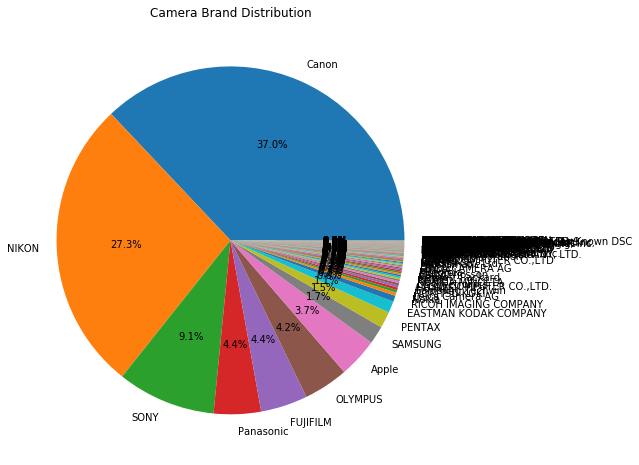

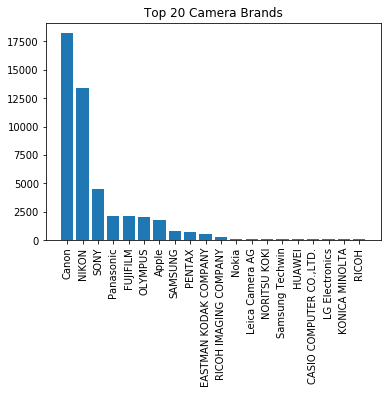

In [20]:
# create figure and axes objects
fig, ax = plt.subplots(figsize=(8, 8))
# get a count of unique camera brands and their occurrences
camera_counts = df['Camera brand'].value_counts()
# create pie chart
ax.pie(camera_counts.values, labels=camera_counts.index, autopct='%1.1f%%')

# set title
ax.set_title('Camera Brand Distribution')

# display plot
plt.show()


# Define the labels and positions for the X axis ticks
labels = camera_counts.index[:20]
positions = range(len(labels))

# Display the chart
plt.bar(positions, camera_counts.values[:20], align='center')
plt.xticks(positions, labels, rotation=90) # Rotate the labels by 90 degrees
plt.title('Top 20 Camera Brands')
plt.show()


After arranging the companies, we see that the absolute majority of the cameras belong to the first 11 companies, with the companies in the first and second position dominating the market.
From looking at the information, we are not interested in keeping values that appear once without a regular pattern. we have narrowed down the research to only companies that actually produce cameras.
#### *During the following actions we will reduce the data frame lines from 74000 to 46000 in this action*


We arranged the columns in a logical order in order to see everything logically and clearly and also for the upcoming investigations
df = pd.read_csv('Cleaned_csv_file1.7.csv')

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Cleaned_csv_file1.7.csv')

# List of desired camera brands
desired_brands = ['Canon', 'NIKON', 'SONY', 'Panasonic', 'FUJIFILM', 'OLYMPUS', 'Apple', 'SAMSUNG',
                  'EASTMAN KODAK COMPANY', 'PENTAX', 'RICOH IMAGING COMPANY']

# Filter rows based on camera brand
df_filtered = df[df['Camera brand'].isin(desired_brands)]

# Display the resulting DataFrame
df = df_filtered

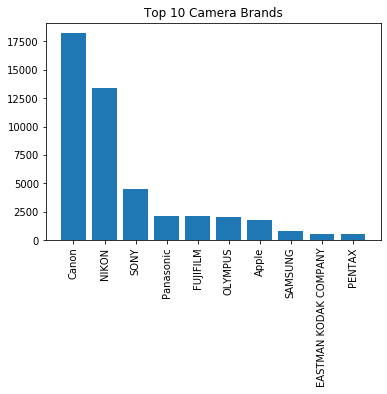

In [22]:
camera_brands = df['Camera brand']
camera_brands_counts = camera_brands.value_counts(sort=True, ascending=False)
# Define the labels and positions for the X axis ticks
labels = camera_brands_counts.index[:10]
positions = range(len(labels))

# Display the chart
plt.bar(positions, camera_brands_counts.values[:10], align='center')
plt.xticks(positions, labels, rotation=90) # Rotate the labels by 90 degrees
plt.title('Top 10 Camera Brands')
plt.show()


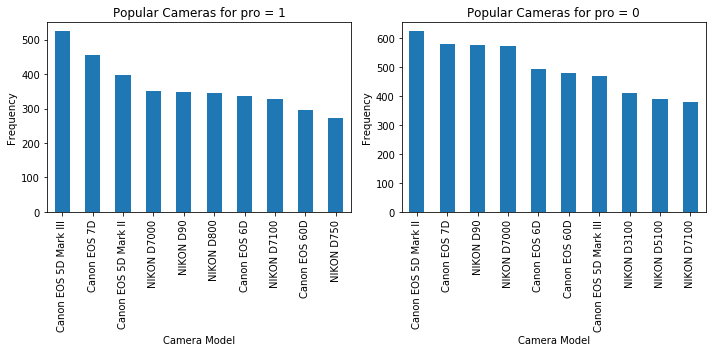

In [23]:
# טעינת הנתונים מקובץ CSV
df = pd.read_csv('Cleaned_csv_file1.3.csv')

# סינון הנתונים לפי ערכי "pro"
popular_cameras_pro_1 = df[df['pro'] == 1]['Camera model'].value_counts()
popular_cameras_pro_0 = df[df['pro'] == 0]['Camera model'].value_counts()

# ציור הדיאגרמות
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
popular_cameras_pro_1[:10].plot(kind='bar')
plt.title('Popular Cameras for pro = 1')
plt.xlabel('Camera Model')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
popular_cameras_pro_0[:10].plot(kind='bar')
plt.title('Popular Cameras for pro = 0')
plt.xlabel('Camera Model')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

We actually investigated whether some people who are PRO prefer a certain brand over the others and thus we might find something that characterizes a PRO.
+ In the new column you can see who shows up more in each brand, pro or non-pro. 

In [51]:
df = pd.read_csv('Cleaned_csv_file1.7.csv')


# Assuming your DataFrame is named 'df'
pro_counts = pd.crosstab(df['Camera brand'], df['pro'])
pro_counts['New Column'] = pro_counts[1] > pro_counts[0]
pro_counts['New Column'] = pro_counts['New Column'].astype(int)
for index, row in df.iterrows():
    camera_brand = row['Camera brand']
    for pro_brand, pro_row in pro_counts.iterrows():
        if pro_brand == camera_brand:
            df.loc[index, 'more_pro_in_brand'] = pro_row['New Column']
            break

# Display the table
print(pro_counts)

pro                              0    1  New Column
Camera brand                                       
  MEDION OPTICAL CO,LTD          0    2           1
--                               1    0           0
3DLUT mobile                     1    0           0
5.2MP DigitalCAM                 1    0           0
5M DSC                           1    0           0
ABILITY ENTERPRISE CO., LTD      0    1           1
ADPK                             1    0           0
AIPTEK                           1    0           0
ALLVIEW                          3    0           0
APPLE                            1    0           0
ASUS                             5    2           0
Adobe Systems Inc.               3    0           0
AgfaPhoto GmbH                   7    1           0
Amazon                           1    3           1
Apple                          949  855           0
Apple + Pro HDR                  2    3           1
Applied Graphics Technologies    1    1           0
Arsenal Fact

In [52]:
df = pd.read_csv('Cleaned_csv_file1.9.csv')


# Assuming your DataFrame is named 'df'
pro_counts = pd.crosstab(df['Camera brand'], df['pro'])
pro_counts['New Column'] = pro_counts[1] > pro_counts[0]
pro_counts['New Column'] = pro_counts['New Column'].astype(int)
for index, row in df.iterrows():
    camera_brand = row['Camera brand']
    for pro_brand, pro_row in pro_counts.iterrows():
        if pro_brand == camera_brand:
            df.loc[index, 'more_pro_in_brand'] = pro_row['New Column']
            break

# Display the table
print(pro_counts)

pro                        0     1  New Column
Camera brand                                  
Apple                    949   853           0
Canon                  11019  7125           0
EASTMAN KODAK COMPANY    351   156           0
FUJIFILM                1293   805           0
NIKON                   8074  5311           0
OLYMPUS                 1144   886           0
PENTAX                   313   195           0
PENTAX Corporation       156    81           0
Panasonic               1153  1002           0
RICOH IMAGING COMPANY    137   142           1
SAMSUNG                  520   303           0
SONY                    2699  1768           0


##### An investigation between pro likes
We researched for every amount of likes that appears, there are many different amounts of likes that repeat themselve.<br />
In the comparison column we see which number dominates the amount of likes for the different amounts.<br />
The motivation for this strange test is to check whether with larger amounts of likes more PROs appear
We did a similar thing for comments and views.<br />
Unfortunately, looking at the data, it seems that there is really no indication that non-pro users receive fewer comments, views and likes.

In [45]:
likes_pro_counts = pd.crosstab(df['likes'], df['pro'])
likes_pro_counts['comparison'] = likes_pro_counts[1] > likes_pro_counts[0]
likes_pro_counts['comparison'] = likes_pro_counts['comparison'].astype(int)
for index, row in df.iterrows():
    likes = row['likes']
    for pro_index, pro_row in likes_pro_counts.iterrows():
        if pro_index == likes:
            df.loc[index, 'Performances in Likes'] = pro_row['comparison']
            break
# Print the updated table
print(likes_pro_counts)

pro       0     1  comparison
likes                        
0      6229  3706           0
1      2675  1752           0
2      1869  1101           0
3      1527   909           0
4      1337   760           0
5      1145   704           0
6       993   625           0
7       847   601           0
8       786   558           0
9       650   436           0
10      622   425           0
11      554   409           0
12      513   359           0
13      456   307           0
14      377   298           0
15      330   256           0
16      338   243           0
17      286   236           0
18      268   198           0
19      263   179           0
20      246   174           0
21      216   170           0
22      197   160           0
23      179   158           0
24      172   126           0
25      160   123           0
26      141   121           0
27      165    95           0
28      118    96           0
29      130   101           0
...     ...   ...         ...
1289      

In [53]:
# במותגים שבדקנו ישנם יותר לא פרו מפרו 
pro_counts = pd.crosstab(df['Camera brand'], df['pro'])

pro_counts['common'] = pro_counts[1] > pro_counts[0]
pro_counts['common'] = pro_counts['common'].astype(int)

# Display the updated table
print(pro_counts)

pro                        0     1  common
Camera brand                              
Apple                    949   853       0
Canon                  11019  7125       0
EASTMAN KODAK COMPANY    351   156       0
FUJIFILM                1293   805       0
NIKON                   8074  5311       0
OLYMPUS                 1144   886       0
PENTAX                   313   195       0
PENTAX Corporation       156    81       0
Panasonic               1153  1002       0
RICOH IMAGING COMPANY    137   142       1
SAMSUNG                  520   303       0
SONY                    2699  1768       0


In [46]:
df.head(3)

,Unnamed: 0,url,tag,view,likes,comments,date,pro,photographer,Camera model,...,EASTMAN KODAK COMPANY,FUJIFILM,NIKON,OLYMPUS,PENTAX,PENTAX Corporation,Panasonic,RICOH IMAGING COMPANY,SAMSUNG,SONY
0,0,https://www.flickr.com/photos/147142755@N07/35...,arizona,63,0,0,2017-07-02,0,Benjamin Locksmith,COOLPIX L840,...,0,0,1,0,0,0,0,0,0,0
1,2,https://www.flickr.com/photos/125355724@N03/14...,arizona,883,1,0,2014-07-26,0,Silverstorm Grim,COOLPIX S3300,...,0,0,1,0,0,0,0,0,0,0
2,3,https://www.flickr.com/photos/bob_haase/508120...,arizona,1197,27,8,2020-12-15,1,Robert Haase,NIKON D850,...,0,0,1,0,0,0,0,0,0,0


##### After investigating the cameras, we want to learn about the different connections between photos from pro users and non-pro users.


c:\Users\matan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


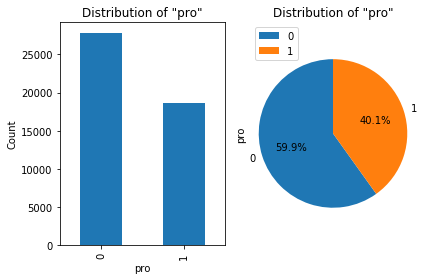

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# טעינת הנתונים מקובץ ה-CSV
data = pd.read_csv('Cleaned_csv_file1.9.csv')

# יצירת דיאגרמת עמודות מונה
pro_counts = data['pro'].value_counts()

# דיאגרמת עמודות
plt.subplot(121)
pro_counts.plot.bar(x='pro', y='Count', title='Distribution of "pro"')
plt.xlabel('pro')
plt.ylabel('Count')

# דיאגרמת עוגה
plt.subplot(122)
pro_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of "pro"')
plt.axis('equal')  # כדי להבטיח שהעוגה תיראה עיגולית
plt.legend()

plt.tight_layout()  # כדי למנוע חפיפה בין הדיאגרמות
plt.show()

 
#### <span style="color:DodgerBlue">Here it is already clear to us that there are more non-Pros than Pros</span>

##### It is important to mention that in every such test we created new columns, usually columns of 0 and 1 in order to differentiate as much as possible between pro and non-pro situations

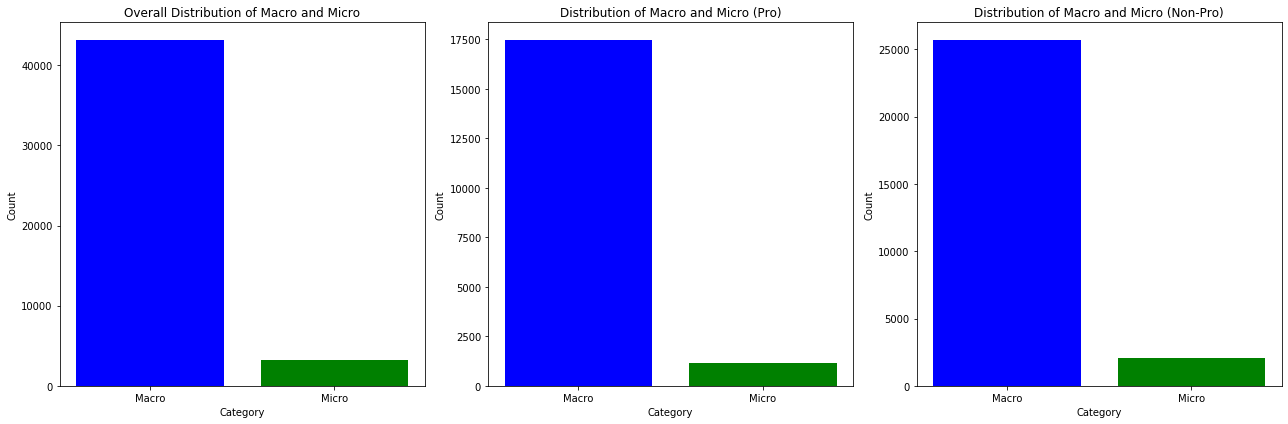

In [49]:
# Count the occurrences of macro and micro in the entire dataset
total_counts = df['macro_or_micro'].value_counts()

# Count the occurrences of macro and micro based on pro == 1
pro_1_counts = df[df['pro'] == 1]['macro_or_micro'].value_counts()

# Count the occurrences of macro and micro based on pro == 0
pro_0_counts = df[df['pro'] == 0]['macro_or_micro'].value_counts()

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot for the overall distribution of macro and micro
axes[0].bar(['Macro', 'Micro'], total_counts, color=['blue', 'green'])
axes[0].set_title('Overall Distribution of Macro and Micro')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')

# Bar plot for the distribution of macro and micro based on pro == 1
axes[1].bar(['Macro', 'Micro'], pro_1_counts, color=['blue', 'green'])
axes[1].set_title('Distribution of Macro and Micro (Pro)')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')

# Bar plot for the distribution of macro and micro based on pro == 0
axes[2].bar(['Macro', 'Micro'], pro_0_counts, color=['blue', 'green'])
axes[2].set_title('Distribution of Macro and Micro (Non-Pro)')
axes[2].set_xlabel('Category')
axes[2].set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In this test, we looked for a connection between the type of photography and the pro feature, in fact we tested whether photographers who specialize in professional photography of close-up objects are more pro.

We created bar graphs that basically show in all cases that1:
1. There are many more non-macro images
2. Pro photographers who shoot nan macro are identical in quantity compared to non-pro photographers who shoot nan macro and that the graphs match the general trend.
3. We have no indication here for a unique feature for users who are pro.

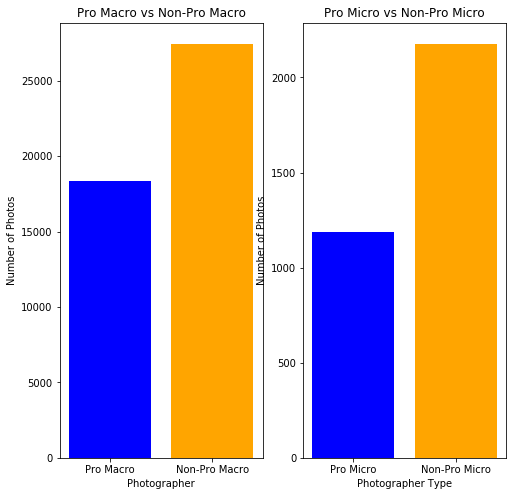

In [12]:
# קובץ הנתונים
data = pd.read_csv('Cleaned_csv_file1.7.csv')

# יצירת מרקם של הגרפים
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8, 8))

# גרף עבור pro_macro vs non_pro_macro
pro_macro = data[(data['macro_or_micro'] == 1) & (data['pro'] == 1)]
non_pro_macro = data[(data['macro_or_micro'] == 1) & (data['pro'] == 0)]
ax1.bar(['Pro Macro', 'Non-Pro Macro'], [len(pro_macro), len(non_pro_macro)],color=['blue','orange'])
ax1.set_xlabel('Photographer')
ax1.set_ylabel('Number of Photos')
ax1.set_title('Pro Macro vs Non-Pro Macro')

# גרף עבור pro_micro vs non_pro_micro
pro_micro = data[(data['macro_or_micro'] == 0) & (data['pro'] == 1)]
non_pro_micro = data[(data['macro_or_micro'] == 0) & (data['pro'] == 0)]
ax2.bar(['Pro Micro', 'Non-Pro Micro'], [len(pro_micro), len(non_pro_micro)],color=['blue','orange'])
ax2.set_xlabel('Photographer Type')
ax2.set_ylabel('Number of Photos')
ax2.set_title('Pro Micro vs Non-Pro Micro')

# הצגת הגרפים
plt.show()

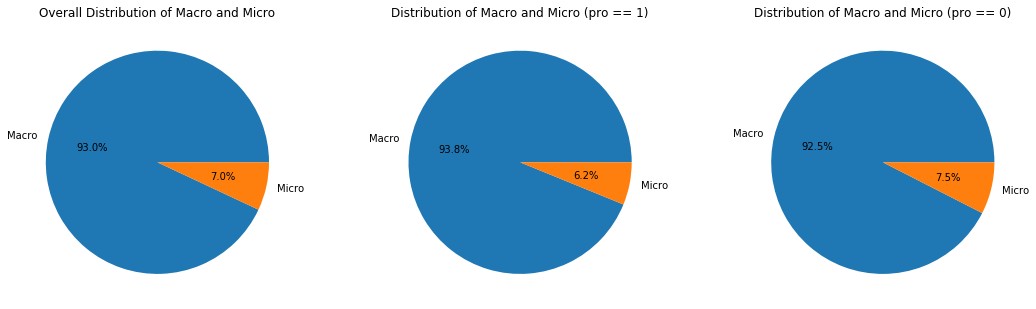

In [51]:
import matplotlib.pyplot as plt

# Count the occurrences of macro and micro in the entire dataset
total_counts = data['macro_or_micro'].value_counts()

# Count the occurrences of macro and micro based on pro == 1
pro_1_counts = data[data['pro'] == 1]['macro_or_micro'].value_counts()

# Count the occurrences of macro and micro based on pro == 0
pro_0_counts = data[data['pro'] == 0]['macro_or_micro'].value_counts()

# Define the color palettes
palette1 = ['#FF9999', '#FFCC99']
palette2 = ['#FF0000', '#FF8000']
palette3 = ['#66CCCC', '#6699CC']
palette4 = ['#FFB266', '#FFD700']

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the overall distribution of macro and micro
axes[0].pie(total_counts, labels=['Macro', 'Micro'], autopct='%1.1f%%')
axes[0].set_title('Overall Distribution of Macro and Micro')

# Plot the distribution of macro and micro based on pro == 1
axes[1].pie(pro_1_counts, labels=['Macro', 'Micro'], autopct='%1.1f%%')
axes[1].set_title('Distribution of Macro and Micro (pro == 1)')

# Plot the distribution of macro and micro based on pro == 0
axes[2].pie(pro_0_counts, labels=['Macro', 'Micro'], autopct='%1.1f%%')
axes[2].set_title('Distribution of Macro and Micro (pro == 0)')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the figure
plt.show()


In order to do some research on the photographers that appear in the table, we created a data frame for them that contains the overall information such as how many times they appear, with which cameras they appear, their type of photography that appears in columns related to the camera data.

Hoping to find features for those pro or non-pro photographers.

In [3]:
# Load the data from the CSV file
data = pd.read_csv('Cleaned_csv_file1.9.csv')

# Group the data by photographer and aggregate the likes, comments, and views columns into a sum
summed_data = data.groupby('photographer', as_index=False)[['likes', 'comments', 'view']].sum()

# Add the "pro" column to the DataFrame
summed_data['pro'] = data['pro']

# Calculate the average of likes/views ratio
summed_data['likes_views_ratio'] = summed_data['likes'] / summed_data['view'].replace(float('inf'), 0)
summed_data['comments_views_ratio'] = summed_data['comments'] / summed_data['view'].replace(float('inf'), 0)

# Replace division by 0 in likes/views ratio with 0
summed_data['likes_views_ratio'] = summed_data['likes_views_ratio'].replace(float('inf'), 0)

# Calculate the average of likes and comments
summed_data['comments_likes_ratio'] = summed_data['comments'] / summed_data['likes'].replace(float('inf'), 0)

# Sort the data by likes in descending order
summed_data = summed_data.sort_values(by='likes', ascending=False)

# Create a new column for the list of cameras
summed_data['cameras'] = ""

# Fill the new column with the list of cameras for each photographer
for index, row in summed_data.iterrows():
    cameras = data[data['photographer'] == row['photographer']]['camera name'].tolist()
    # Remove duplicates from the list of cameras
    cameras = list(set(cameras))
    summed_data.at[index, 'cameras'] = cameras

# Create a new column for the list of tags
summed_data['tags'] = ""

# Fill the new column with the list of tags for each photographer
for index, row in summed_data.iterrows():
    tags = data[data['photographer'] == row['photographer']]['tag'].tolist()
    # Remove duplicates from the list of tags
    tags = list(set(tags))
    summed_data.at[index, 'tags'] = tags

# Create a new column for the list of dates
summed_data['dates'] = ""

# Fill the new column with the list of dates for each photographer
for index, row in summed_data.iterrows():
    dates = data[data['photographer'] == row['photographer']]['date'].tolist()
    # Remove duplicates from the list of dates
    dates1 = list(sorted(dates, key=lambda x: str(x)))
    summed_data.at[index, 'dates'] = dates


# Save the updated DataFrame to CSV
summed_data.to_csv('summed_data_per_photographer1.csv', index=False)

# Display the resulting DataFrame
display(summed_data)

c:\Users\matan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


KeyboardInterrupt: 

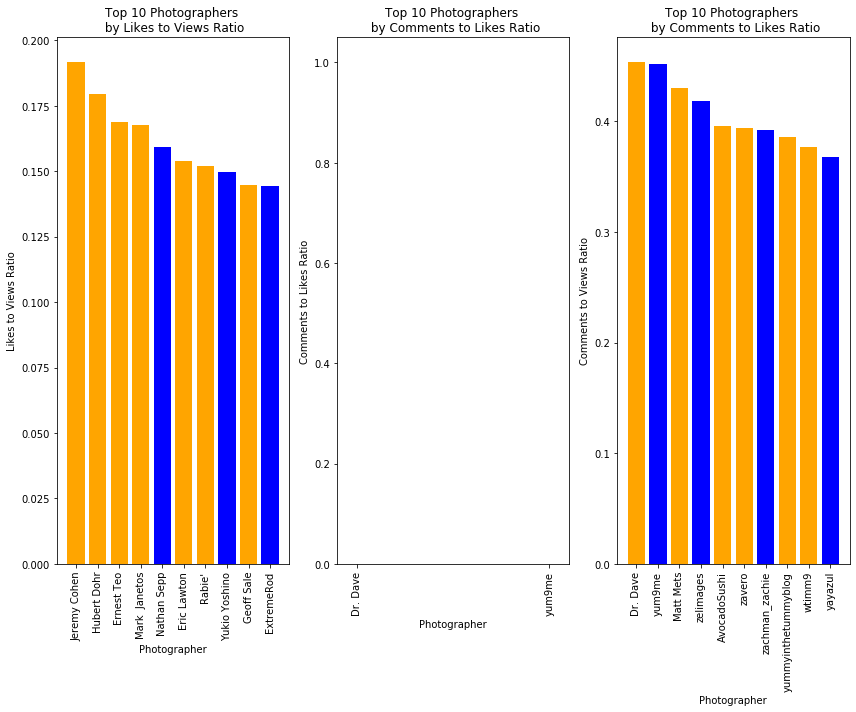

In [ ]:
# Read the CSV file
df = pd.read_csv("summed_data_per_photographer1.csv", header=0)
df['comments_likes_ratio'].replace('inf', 0, inplace=True)

# Sort the DataFrame by `likes_views_ratio` in descending order and take the top 10 rows
df_top10_likes_to_views = df.sort_values(by="likes_views_ratio", ascending=False).head(10)

# Sort the DataFrame by `comments_likes_ratio` in descending order and take the top 10 rows
df_top10_comments_likes_ratio = df.sort_values(by="comments_likes_ratio", ascending=False).head(10)

# Sort the DataFrame by `comments_views_ratio` in descending order and take the top 10 rows
df_top10_comments_views_ratio = df.sort_values(by="comments_views_ratio", ascending=False).head(10)

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 10))

# Define colors for the bars
colors = ["orange" if value == 0 else "blue" for value in df_top10_likes_to_views["pro"]]

# Plot the top 10 photographers by likes to views ratio with colored bars
ax1.bar(df_top10_likes_to_views["photographer"], df_top10_likes_to_views["likes_views_ratio"], color=colors)
ax1.set_xticklabels(df_top10_likes_to_views["photographer"], rotation=90)
ax1.set_ylabel("Likes to Views Ratio")
ax1.set_xlabel("Photographer")
ax1.set_title("Top 10 Photographers \n by Likes to Views Ratio")

# Define colors for the bars
colors = ["orange" if value == 0 else "blue" for value in df_top10_comments_likes_ratio["pro"]]

# Plot the top 10 photographers by comments to likes ratio with colored bars
ax2.bar(df_top10_comments_likes_ratio["photographer"], df_top10_comments_likes_ratio["comments_likes_ratio"], color=colors)
ax2.set_xticklabels(df_top10_comments_likes_ratio["photographer"], rotation=90)
ax2.set_ylabel("Comments to Likes Ratio")
ax2.set_xlabel("Photographer")
ax2.set_title("Top 10 Photographers \n by Comments to Likes Ratio")

# Define colors for the bars
colors = ["orange" if value == 0 else "blue" for value in df_top10_comments_views_ratio["pro"]]

# Plot the top 10 photographers by comments to views ratio with colored bars
ax3.bar(df_top10_comments_likes_ratio["photographer"], df_top10_comments_views_ratio["comments_views_ratio"], color=colors)
ax3.set_xticklabels(df_top10_comments_likes_ratio["photographer"], rotation=90)
ax3.set_ylabel("Comments to Views Ratio")
ax3.set_xlabel("Photographer")
ax3.set_title("Top 10 Photographers \n by Comments to Likes Ratio")

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("top_10_photographers.png")
plt.show()



c:\Users\matan\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\matan\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


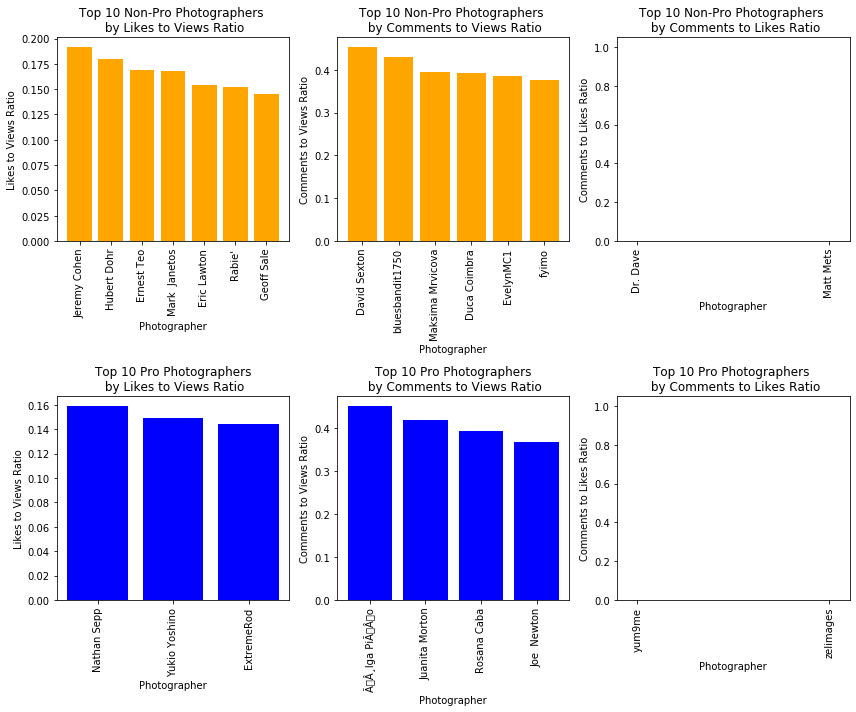

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("summed_data_per_photographer1.csv", header=0)
df['comments_likes_ratio'].replace('inf', 0, inplace=True)

# Sort the DataFrame by `likes_views_ratio` in descending order and take the top 10 rows
df_top10_likes_to_views = df.sort_values(by="likes_views_ratio", ascending=False).head(10)

# Sort the DataFrame by `comments_likes_ratio` in descending order and take the top 10 rows
df_top10_comments_likes_ratio = df.sort_values(by="comments_likes_ratio", ascending=False).head(10)

# Sort the DataFrame by `comments_views_ratio` in descending order and take the top 10 rows
df_top10_comments_views_ratio = df.sort_values(by="comments_views_ratio", ascending=False).head(10)

# Create a figure with six subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 10))

# Define colors for non-pro photographers (pro == 0) and pro photographers (pro == 1)
colors_non_pro = "orange"
colors_pro = "blue"

# Plot the top 10 non-pro photographers by likes to views ratio with non-pro color
ax1.bar(df_top10_likes_to_views[df_top10_likes_to_views["pro"] == 0]["photographer"], df_top10_likes_to_views[df_top10_likes_to_views["pro"] == 0]["likes_views_ratio"], color=colors_non_pro)
ax1.set_xticklabels(df_top10_likes_to_views[df_top10_likes_to_views["pro"] == 0]["photographer"], rotation=90)
ax1.set_ylabel("Likes to Views Ratio")
ax1.set_xlabel("Photographer")
ax1.set_title("Top 10 Non-Pro Photographers \n by Likes to Views Ratio")

# Plot the top 10 non-pro photographers by comments to views ratio with non-pro color
ax2.bar(df_top10_comments_views_ratio[df_top10_comments_views_ratio["pro"] == 0]["photographer"], df_top10_comments_views_ratio[df_top10_comments_views_ratio["pro"] == 0]["comments_views_ratio"], color=colors_non_pro)
ax2.set_xticklabels(df_top10_comments_views_ratio[df_top10_comments_views_ratio["pro"] == 0]["photographer"], rotation=90)
ax2.set_ylabel("Comments to Views Ratio")
ax2.set_xlabel("Photographer")
ax2.set_title("Top 10 Non-Pro Photographers \n by Comments to Views Ratio")

# Plot the top 10 non-pro photographers by comments to likes ratio with non-pro color
ax3.bar(df_top10_comments_likes_ratio[df_top10_comments_likes_ratio["pro"] == 0]["photographer"], df_top10_comments_likes_ratio[df_top10_comments_likes_ratio["pro"] == 0]["comments_likes_ratio"], color=colors_non_pro)
ax3.set_xticklabels(df_top10_comments_likes_ratio[df_top10_comments_likes_ratio["pro"] == 0]["photographer"], rotation=90)
ax3.set_ylabel("Comments to Likes Ratio")
ax3.set_xlabel("Photographer")
ax3.set_title("Top 10 Non-Pro Photographers \n by Comments to Likes Ratio")

# Plot the top 10 pro photographers by likes to views ratio with pro color
ax4.bar(df_top10_likes_to_views[df_top10_likes_to_views["pro"] == 1]["photographer"], df_top10_likes_to_views[df_top10_likes_to_views["pro"] == 1]["likes_views_ratio"], color=colors_pro)
ax4.set_xticklabels(df_top10_likes_to_views[df_top10_likes_to_views["pro"] == 1]["photographer"], rotation=90)
ax4.set_ylabel("Likes to Views Ratio")
ax4.set_xlabel("Photographer")
ax4.set_title("Top 10 Pro Photographers\n by Likes to Views Ratio")

# Plot the top 10 pro photographers by comments to views ratio with pro color
ax5.bar(df_top10_comments_views_ratio[df_top10_comments_views_ratio["pro"] == 1]["photographer"], df_top10_comments_views_ratio[df_top10_comments_views_ratio["pro"] == 1]["comments_views_ratio"], color=colors_pro)
ax5.set_xticklabels(df_top10_comments_views_ratio[df_top10_comments_views_ratio["pro"] == 1]["photographer"], rotation=90)
ax5.set_ylabel("Comments to Views Ratio")
ax5.set_xlabel("Photographer")
ax5.set_title("Top 10 Pro Photographers\n by Comments to Views Ratio")

# Plot the top 10 pro photographers by comments to likes ratio with pro color
ax6.bar(df_top10_comments_likes_ratio[df_top10_comments_likes_ratio["pro"] == 1]["photographer"], df_top10_comments_likes_ratio[df_top10_comments_likes_ratio["pro"] == 1]["comments_likes_ratio"], color=colors_pro)
ax6.set_xticklabels(df_top10_comments_likes_ratio[df_top10_comments_likes_ratio["pro"] == 1]["photographer"], rotation=90)
ax6.set_ylabel("Comments to Likes Ratio")
ax6.set_xlabel("Photographer")
ax6.set_title("Top 10 Pro Photographers \n by Comments to Likes Ratio")

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("top_10_photographers.png")
plt.show()

In [60]:
df = pd.read_csv('Cleaned_csv_file1.9.csv')

c:\Users\matan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'Comments to Likes Ratio - Pro vs. Non-Pro Photographers')

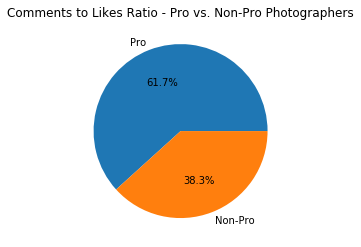

In [61]:
pro_likes_comments_ratio = df[df['pro'] == 1]['comments_likes_ratio'].head().sum()
non_pro_likes_comments_ratio = df[df['pro'] == 0]['comments_likes_ratio'].head().sum()

plt.pie([pro_likes_comments_ratio, non_pro_likes_comments_ratio], labels=['Pro', 'Non-Pro'], autopct='%1.1f%%')
plt.title('Comments to Likes Ratio - Pro vs. Non-Pro Photographers')

Text(0.5, 1.0, 'Comments to Likes Ratio Top 10 - \n Pro vs. Non-Pro Photographers')

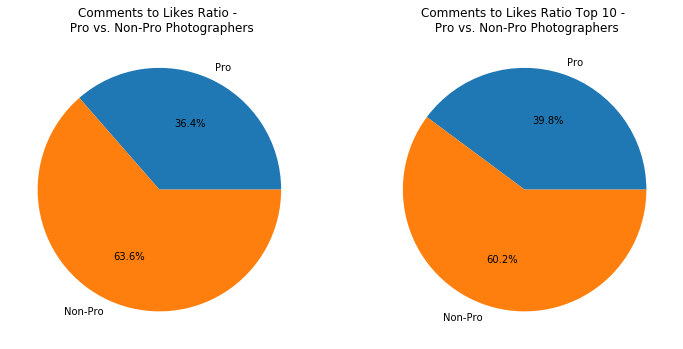

In [66]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 10))
df_comments_likes_ratio = df.sort_values(by="comments_likes_ratio", ascending=False)
pro_likes_comments_ratio = df_comments_likes_ratio[df_comments_likes_ratio['pro'] == 1]['comments_likes_ratio'].sum()
non_pro_likes_comments_ratio = df_comments_likes_ratio[df_comments_likes_ratio['pro'] == 0]['comments_likes_ratio'].sum()
pro_likes_commentsTop10_ratio = df_comments_likes_ratio[df_comments_likes_ratio['pro'] == 1]['comments_likes_ratio'].head(10).sum()
non_pro_likes_commentsTop10_ratio = df_comments_likes_ratio[df_comments_likes_ratio['pro'] == 0]['comments_likes_ratio'].head(10).sum()

non_pro_likes_comments_ratio = df_comments_likes_ratio[df_comments_likes_ratio['pro'] == 0]['comments_likes_ratio'].sum()
ax1.pie([pro_likes_comments_ratio, non_pro_likes_comments_ratio], labels=['Pro', 'Non-Pro'], autopct='%1.1f%%')
ax1.set_title('Comments to Likes Ratio - \n Pro vs. Non-Pro Photographers')
ax2.pie([pro_likes_commentsTop10_ratio, non_pro_likes_commentsTop10_ratio], labels=['Pro', 'Non-Pro'], autopct='%1.1f%%')
ax2.set_title('Comments to Likes Ratio Top 10 - \n Pro vs. Non-Pro Photographers')

NameError: name 'df_top10_Likes_to_views_non_pro' is not defined

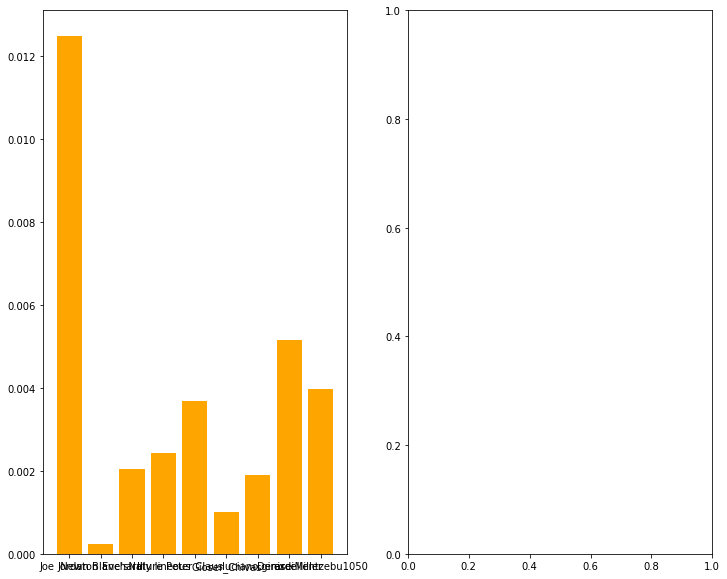

In [68]:
fig, ((ax7, ax8)) = plt.subplots(1, 2, figsize=(12, 10))
# Plot the top 10 pro photographers by likes to views ratio
df_top10_comments_likes_ratio_non_pro = df[df["pro"] == 0].sort_values(by="comments_likes_ratio", ascending=False).head(10)

# Plot the top 10 non-pro photographers by likes to views ratio
ax7.bar(df_top10_comments_likes_ratio_non_pro["photographer"], df_top10_comments_likes_ratio_non_pro["likes_views_ratio"],color='orange')
ax7.set_xticklabels(df_top10_Likes_to_views_non_pro["photographer"], rotation=90)
ax7.set_ylabel("comments_likes_ratio_non_pro")
ax7.set_xlabel("Photographer")
ax7.set_title("Top 10 Non-Pro Photographers by Comments to Views Ratio")

df_top10_comments_likes_ratio_pro = df[df["pro"] == 1].sort_values(by="comments_likes_ratio", ascending=False).head(10)
# Plot the top 10 pro photographers by comments to views ratio
ax8.bar(df_top10_comments_likes_ratio_pro["photographer"], df_top10_comments_likes_ratio_pro["comments_likes_ratio"])
ax8.set_xticklabels(df_top10_Comments_views_ratio_pro["photographer"], rotation=90)
ax8.set_ylabel("comments_likes_ratio_pro")
ax8.set_xlabel("Photographer")
ax8.set_title("Top 10 Pro Photographers by Comments to Views Ratio")
# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("top_10_photographers.png")
plt.show()

NameError: name 'df_top10_Likes_to_views_non_pro' is not defined

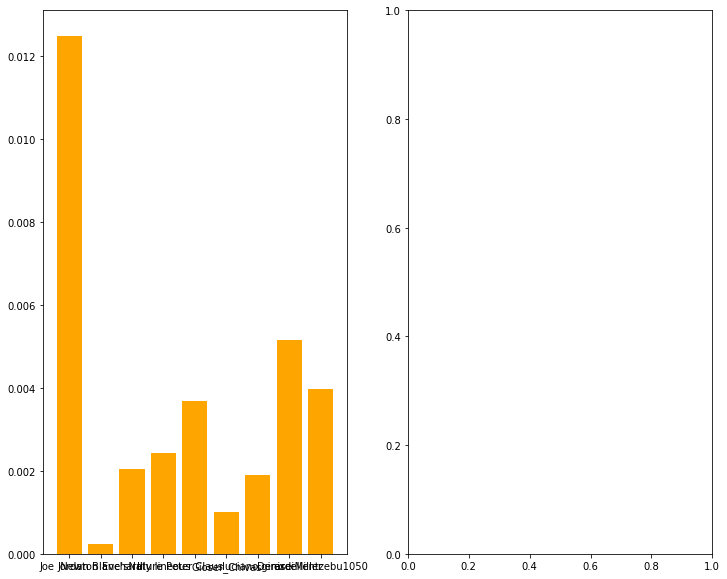

In [64]:
fig, ((ax7, ax8)) = plt.subplots(1, 2, figsize=(12, 10))
# Plot the top 10 pro photographers by likes to views ratio
df_top10_comments_likes_ratio_non_pro = df[df["pro"] == 0].sort_values(by="comments_likes_ratio", ascending=False).head(10)

# Plot the top 10 non-pro photographers by likes to views ratio
ax7.bar(df_top10_comments_likes_ratio_non_pro["photographer"], df_top10_comments_likes_ratio_non_pro["likes_views_ratio"],color='orange')
ax7.set_xticklabels(df_top10_Likes_to_views_non_pro["photographer"], rotation=90)
ax7.set_ylabel("comments_likes_ratio_non_pro")
ax7.set_xlabel("Photographer")
ax7.set_title("Top 10 Non-Pro Photographers by Comments to Views Ratio")

df_top10_comments_likes_ratio_pro = df[df["pro"] == 1].sort_values(by="comments_likes_ratio", ascending=False).head(10)
# Plot the top 10 pro photographers by comments to views ratio
ax8.bar(df_top10_comments_likes_ratio_pro["photographer"], df_top10_comments_likes_ratio_pro["comments_likes_ratio"])
ax8.set_xticklabels(df_top10_Comments_views_ratio_pro["photographer"], rotation=90)
ax8.set_ylabel("comments_likes_ratio_pro")
ax8.set_xlabel("Photographer")
ax8.set_title("Top 10 Pro Photographers by Comments to Views Ratio")
# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("top_10_photographers.png")
plt.show()


 + Another experiment in which we looked for logic that we might have a higher ratio of likes for views and in addition more expectations for pro users which turned out to be not true at all

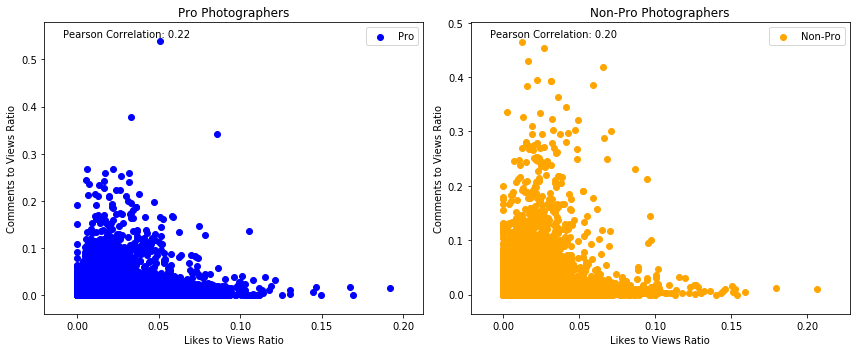

In [9]:
# Read the CSV file
df = pd.read_csv("Cleaned_csv_file1.9.csv", header=0)
df['comments_likes_ratio'].replace('inf', 0)

# Calculate Pearson correlation coefficient
pro_corr = df[df["pro"] == 1]["likes_views_ratio"].corr(df[df["pro"] == 1]["comments_views_ratio"])
non_pro_corr = df[df["pro"] == 0]["likes_views_ratio"].corr(df[df["pro"] == 0]["comments_views_ratio"])

# Create a figure with one row and two columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for pro photographers with Pearson correlation coefficient
ax1.scatter(df[df["pro"] == 1]["likes_views_ratio"], df[df["pro"] == 1]["comments_views_ratio"], color="blue", label="Pro")
ax1.annotate(f"Pearson Correlation: {pro_corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
ax1.set_xlabel("Likes to Views Ratio")
ax1.set_ylabel("Comments to Views Ratio")
ax1.set_title("Pro Photographers")
ax1.legend()

# Scatter plot for non-pro photographers with Pearson correlation coefficient
ax2.scatter(df[df["pro"] == 0]["likes_views_ratio"], df[df["pro"] == 0]["comments_views_ratio"], color="orange", label="Non-Pro")
ax2.annotate(f"Pearson Correlation: {non_pro_corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
ax2.set_xlabel("Likes to Views Ratio")
ax2.set_ylabel("Comments to Views Ratio")
ax2.set_title("Non-Pro Photographers")
ax2.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("pro_non_pro_scatter.png")
plt.show()

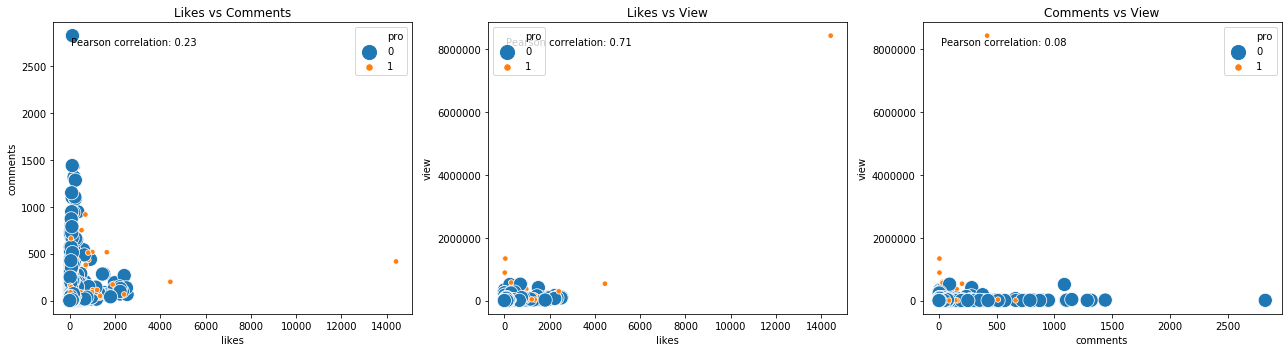

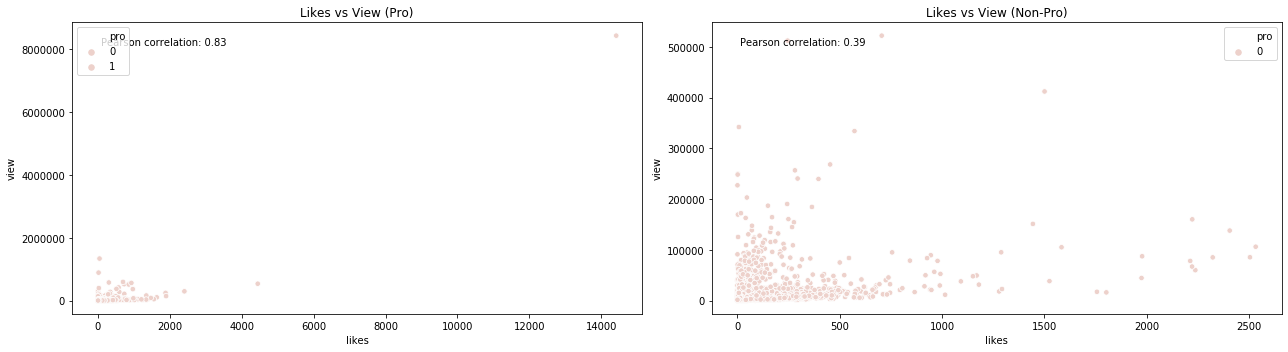

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Read the CSV file
df = pd.read_csv('Cleaned_csv_file1.9.csv')

# Create a graph with columns "likes" and "comments" relative to the "pro" column
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df, x="likes", y="comments", hue="pro", size="pro", sizes=(30, 200), ax=ax1)
ax1.set_title('Likes vs Comments')

# Calculate Pearson's correlation
corr1, _ = pearsonr(df['likes'], df['comments'])

# Add Pearson's correlation to the graph
textstr1 = f'Pearson correlation: {corr1:.2f}'
ax1.text(0.05, 0.95, textstr1, transform=ax1.transAxes, va='top')

sns.scatterplot(data=df, x="likes", y="view", hue="pro", size="pro", sizes=(30, 200), ax=ax2)
ax2.set_title('Likes vs View')

corr2, _ = pearsonr(df['likes'], df['view'])
textstr2 = f'Pearson correlation: {corr2:.2f}'
ax2.text(0.05, 0.95, textstr2, transform=ax2.transAxes, va='top')

sns.scatterplot(data=df, x="comments", y="view", hue="pro", size="pro", sizes=(30, 200), ax=ax3)
ax3.set_title('Comments vs View')

corr3, _ = pearsonr(df['comments'], df['view'])
textstr3 = f'Pearson correlation: {corr3:.2f}'
ax3.text(0.05, 0.95, textstr3, transform=ax3.transAxes, va='top')

plt.tight_layout()
plt.show()

fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(18, 5))

df_filtered = df[df['pro'] == 1]

sns.scatterplot(data=df_filtered, x="likes", y="view", hue="pro", size="pro", sizes=(30, 200), ax=ax4)
ax4.set_title('Likes vs View (Pro)')

corr, _ = pearsonr(df_filtered['likes'], df_filtered['view'])
textstr = f'Pearson correlation: {corr:.2f}'
ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes, va='top')

df_filtered1 = df[df['pro'] == 0]

sns.scatterplot(data=df_filtered1, x="likes", y="view", hue="pro", size="pro", sizes=(30, 200), ax=ax5)
ax5.set_title('Likes vs View (Non-Pro)')

corr, _ = pearsonr(df_filtered1['likes'], df_filtered1['view'])
textstr = f'Pearson correlation: {corr:.2f}'
ax5.text(0.05, 0.95, textstr, transform=ax5.transAxes, va='top')

plt.tight_layout()
plt.show()

Text(0.05, 0.95, 'Pearson Correlation: 0.08')

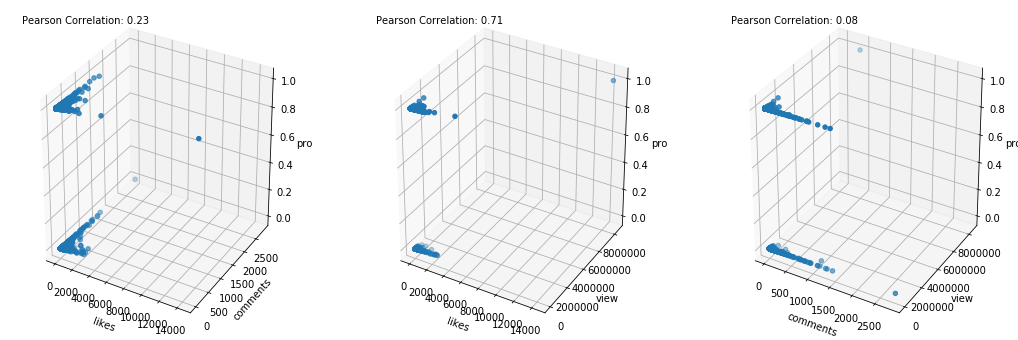

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr

# טעינת הנתונים מהקובץ
data = pd.read_csv('Cleaned_csv_file1.9.csv')

# הגדרת המשתנים על פי העמודות הנדרשות
x = pd.to_numeric(data['likes'])
y = pd.to_numeric(data['comments'])
z = pd.to_numeric(data['pro'])

# יצירת תרשים 3D עבור הנתונים likes, comments, pro
fig = plt.figure(figsize=(18, 6))

# תרשים הראשון
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(x, y, z)
ax1.set_xlabel('likes')
ax1.set_ylabel('comments')
ax1.set_zlabel('pro')

# תרשים השני
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(x, pd.to_numeric(data['view']), z)
ax2.set_xlabel('likes')
ax2.set_ylabel('view')
ax2.set_zlabel('pro')

# תרשים השלישי
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(y, pd.to_numeric(data['view']), z)
ax3.set_xlabel('comments')
ax3.set_ylabel('view')
ax3.set_zlabel('pro')

# חישוב מקדם הפירסון
corr1, _ = pearsonr(x, y)
corr2, _ = pearsonr(x, pd.to_numeric(data['view']))
corr3, _ = pearsonr(y, pd.to_numeric(data['view']))

# הצגת מקדמי הפירסון
ax1.text2D(0.05, 0.95, f'Pearson Correlation: {corr1:.2f}', transform=ax1.transAxes)
ax2.text2D(0.05, 0.95, f'Pearson Correlation: {corr2:.2f}', transform=ax2.transAxes)
ax3.text2D(0.05, 0.95, f'Pearson Correlation: {corr3:.2f}', transform=ax3.transAxes)

When we directly explored the data graphs that are right here we actually realized that we might be missing something important.

We kept looking for a connection between larger amounts of likes and views and whether a user is a pro, at this point we see that maybe the connection is very weak or even non-existent and that there is no effect between the social characteristics of the site and whether a user is a pro and it is likely that there is something else that determines whether a user is Pro or not, so in the next section we will simplify this test and meticulously check whether there are connections between the social variables and whether a user is a pro or not a pro

c:\Users\matan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


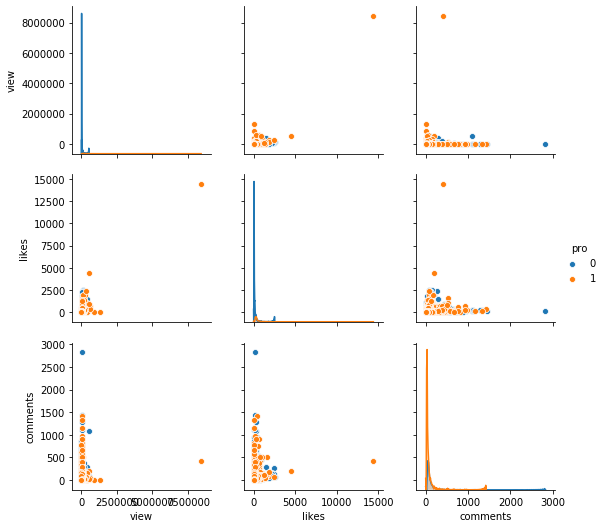

In [7]:
import seaborn as sns
import pandas as pd


data = pd.read_csv('Cleaned_csv_file1.9.csv')

sns.pairplot(data, vars=['view', 'likes', 'comments'], hue='pro')

plt.show()

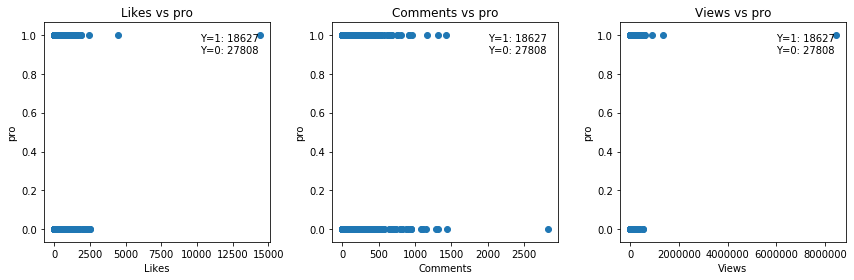

In [73]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Scatter plot for 'likes' column
likes_plot = axes[0].scatter(df['likes'], df['pro'])
axes[0].set_xlabel('Likes')
axes[0].set_ylabel('pro')
axes[0].set_title('Likes vs pro')
axes[0].text(0.95, 0.95, f"Y=1: {sum(df['pro'] == 1)}\nY=0: {sum(df['pro'] == 0)}",
             transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right')

# Scatter plot for 'comments' column
comments_plot = axes[1].scatter(df['comments'], df['pro'])
axes[1].set_xlabel('Comments')
axes[1].set_ylabel('pro')
axes[1].set_title('Comments vs pro')
axes[1].text(0.95, 0.95, f"Y=1: {sum(df['pro'] == 1)}\nY=0: {sum(df['pro'] == 0)}",
             transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right')

# Scatter plot for 'view' column
views_plot = axes[2].scatter(df['view'], df['pro'])
axes[2].set_xlabel('Views')
axes[2].set_ylabel('pro')
axes[2].set_title('Views vs pro')
axes[2].text(0.95, 0.95, f"Y=1: {sum(df['pro'] == 1)}\nY=0: {sum(df['pro'] == 0)}",
             transform=axes[2].transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [74]:
# Assuming you have a data frame called df with columns: likes, comments, views, pro

# Calculate the correlation coefficient
correlation_likes = df['likes'].corr(df['pro'])
correlation_comments = df['comments'].corr(df['pro'])
correlation_views = df['view'].corr(df['pro'])

print("Correlation coefficient between 'likes' and 'pro':", correlation_likes)
print("Correlation coefficient between 'comments' and 'pro':", correlation_comments)
print("Correlation coefficient between 'views' and 'pro':", correlation_views)


Correlation coefficient between 'likes' and 'pro': 0.021784754784267123
Correlation coefficient between 'comments' and 'pro': 0.00941584137871338
Correlation coefficient between 'views' and 'pro': 0.0073895582266121675


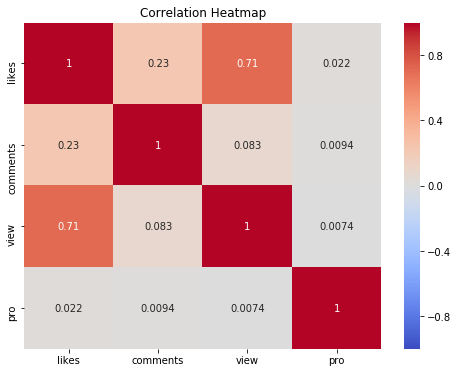

In [75]:
# Assuming you have a data frame called df with columns: likes, comments, views, pro

# Create a correlation matrix
corr_matrix = df[['likes', 'comments', 'view', 'pro']].corr()

# Generate a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Here we see the failure, there is no connection at all between the three variables, we will change direction in order to look for something that might give us a better direction to differentiate between pro and non pro

We did not try to check whether the years in which the site worked had a connection to the pro and non-pro users over the years.

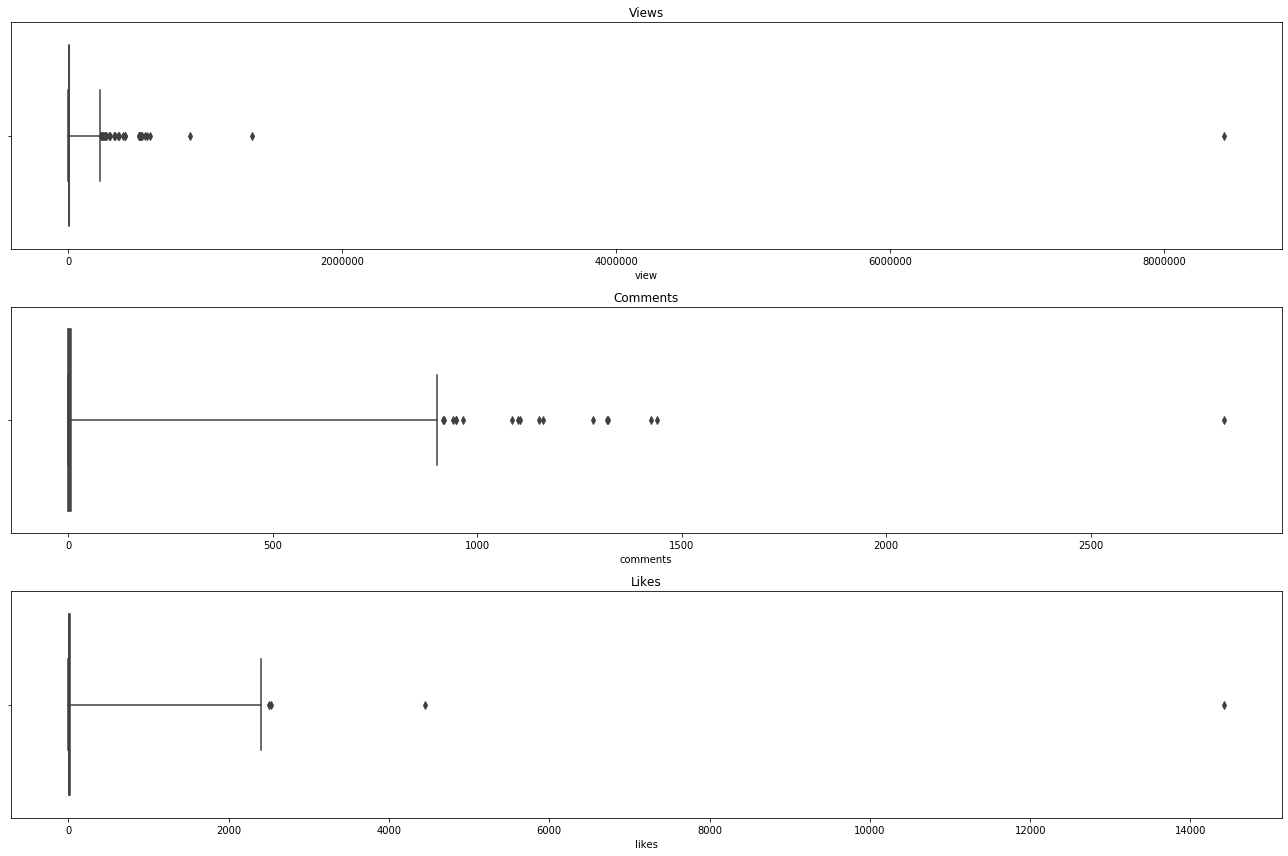

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

# First subplot for "views"
ax1 = axes[0]
sns.boxplot(df['view'], ax=ax1, whis=150)
ax1.set_title('Views')

# Second subplot for "comments"
ax2 = axes[1]
sns.boxplot(df['comments'], ax=ax2, whis=150)
ax2.set_title('Comments')

# Third subplot for "likes"
ax3 = axes[2]
sns.boxplot(df['likes'], ax=ax3, whis=150)
ax3.set_title('Likes')

plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()


It is important to emphasize that the definition of an outlier is not clear-cut, a certain value can be an outlier according to certain methods, and it is not necessarily wrong either.

In [23]:
df = pd.read_csv('cleaned_csv_file1.8.csv')

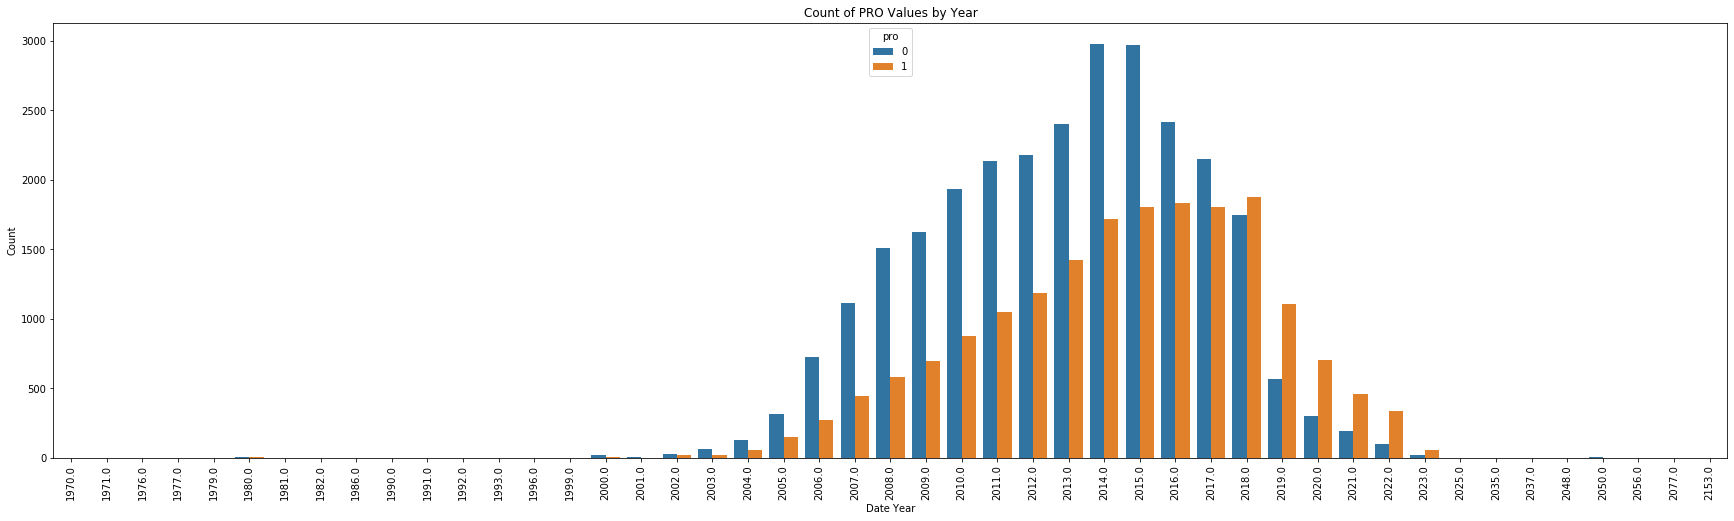

In [24]:
plt.figure(figsize=(30, 8))
sns.countplot(data=df, x='date year', hue='pro')
plt.xlabel('Date Year')
plt.ylabel('Count')
plt.title('Count of PRO Values by Year')
plt.xticks(rotation=90)
plt.show()

We definitely see something strange there are years beyond 2023 and before the site opened in 2004

In [15]:
df['most pro in year'] = (df['date year'] > 2017).astype(int)
df.loc[df['date year'] < 2018, 'most pro in year'] = 0


After correction of the data frame:

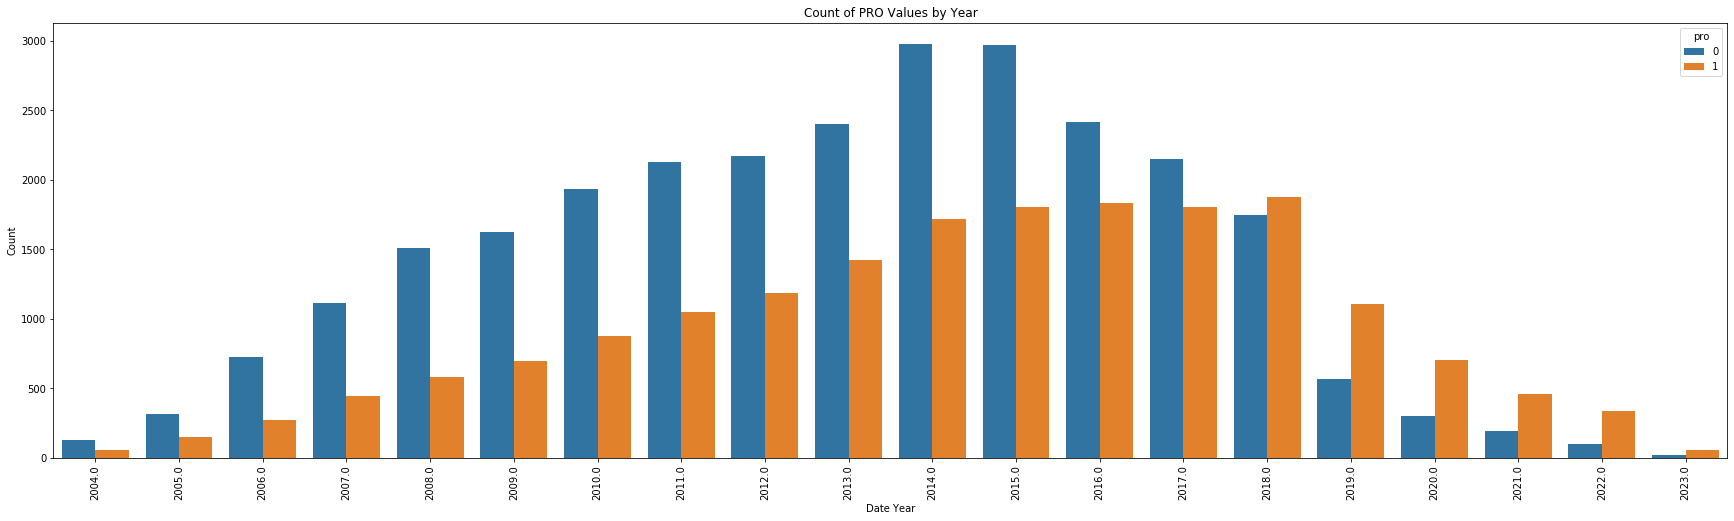

In [25]:
df = pd.read_csv('cleaned_csv_file1.9.csv')
plt.figure(figsize=(30, 8))
sns.countplot(data=df, x='date year', hue='pro')
plt.xlabel('Date Year')
plt.ylabel('Count')
plt.title('Count of PRO Values by Year')
plt.xticks(rotation=90)
plt.show()

+ Cleaning the information from false years such as before the establishment of Flickr or more than 2023.
+ An investigation of how many pro and non-pro there are in each year.
+ Creating a column of years before and after 2018

Finally, we will start with machine learning, we understand that there is a weak relationship between reactions to likes and views but we see trends such as cameras that have a higher percentage of pro and also in the division by years, photos taken after 2018 indicate that there are more PRO users after that year.

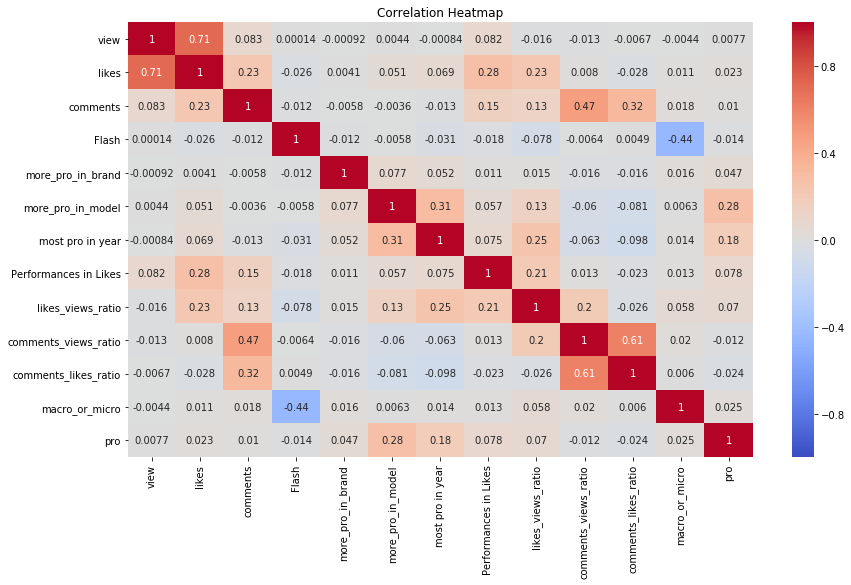

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create a correlation matrix
corr_matrix = df[['view','likes','comments','Flash','more_pro_in_brand','more_pro_in_model','most pro in year','Performances in Likes','likes_views_ratio','comments_views_ratio','comments_likes_ratio','macro_or_micro','pro']].corr()

# Generate a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

After studying all the data we understand that there may not be strong enough relationships between all the variables and whether a user is a pro, further investigation is required.<br />
We are starting to validate our machine learning:
At the beginning we using all the variables, then we will remove the variables with a weak connection that may confuse the <br />machine and finally we will use only the strongest connections

We tried to do a lot of experiments, many experiments included adding and deleting Features for machine learning, additional attempts included experimenting with different models of machine learning, but since we mainly created columns of vectors with characteristics of 0 and 1 only, the logistic regression gave us the best result in the project <br />


At first we see an attempt at machine learning for strongly and weakly correlated parameters

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# קריאת הנתונים מקובץ CSV
df = pd.read_csv("Cleaned_csv_file1.7.csv")

X = df[['view','likes','comments','Flash','more_pro_in_brand','more_pro_in_model','most pro in year','Performances in Likes','likes_views_ratio','comments_views_ratio','comments_likes_ratio','macro_or_micro']]  # Features
y = df['pro'] 

# חלוקת הנתונים לסט האימון והבדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# יצירת ואימון המודל לוגיסטי רגרסיה
model = LogisticRegression()
model.fit(X_train, y_train)

# חיזוי התוויות עבור סט הבדיקה
y_pred = model.predict(X_test)

# השוואה לערכים של 1
y_pred_1 = (y_pred ==1)

confusion_mtx = confusion_matrix(y_test, y_pred)

true_negative, false_positive, false_negative, true_positive = confusion_mtx.ravel()

# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Calculate recall (also known as sensitivity or true positive rate)
recall = true_positive / (true_positive + false_negative)

# Calculate precision (also known as positive predictive value)
precision = true_positive / (true_positive + false_positive)

# Calculate F-measure (also known as F1-score)
f_measure = 2 * (precision * recall) / (precision + recall)

print('true_negative',true_negative)
print('false_positive',false_positive)
print('false_negative',false_negative)
print('true_positive',true_positive)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F-measure:", f_measure)
# Print the values

c:\Users\matan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


true_negative 5917
false_positive 50
false_negative 3792
true_positive 81
Accuracy: 0.6095528455284552
Recall: 0.020914020139426802
Precision: 0.6183206106870229
F-measure: 0.04045954045954046


c:\Users\matan\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The results are disappointing, we will try again this time we will discard columns that had a weak connection with the pro column in the data and create new columns.
These columns are the product of data exploration and the layout of information into vectors.

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# קריאת הנתונים מקובץ CSV
df = pd.read_csv("Cleaned_csv_file1.9.csv")
# ,'likes'
X = df[['more_pro_in_model','most pro in year','Year_2019.0']]  # Features
y = df['pro'] 

# חלוקת הנתונים לסט האימון והבדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# יצירת ואימון המודל לוגיסטי רגרסיה
model = LogisticRegression()
model.fit(X_train, y_train)

# חיזוי התוויות עבור סט הבדיקה
y_pred = model.predict(X_test)

# השוואה לערכים של 1
y_pred_1 = (y_pred ==1)

confusion_mtx = confusion_matrix(y_test, y_pred)

true_negative, false_positive, false_negative, true_positive = confusion_mtx.ravel()

# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Calculate recall (also known as sensitivity or true positive rate)
recall = true_positive / (true_positive + false_negative)

# Calculate precision (also known as positive predictive value)
precision = true_positive / (true_positive + false_positive)

# Calculate F-measure (also known as F1-score)
f_measure = 2 * (precision * recall) / (precision + recall)

print('true_negative',true_negative)
print('false_positive',false_positive)
print('false_negative',false_negative)
print('true_positive',true_positive)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F-measure:", f_measure)
# Print the values

true_negative 4697
false_positive 836
false_negative 2246
true_positive 1508
Accuracy: 0.668138257779692
Recall: 0.40170484816196056
Precision: 0.643344709897611
F-measure: 0.4945883896359462


c:\Users\matan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\Users\matan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


getting better. We want to improve the machine learning a little more, at this stage we went back and researched what enables better results in the machine learning and logistic regression process, and we discovered some interesting things.<br />

1. The machine learning of the logistic regression is affected by the order of the vectors entering it.
2. Columns with a weak connection with the tested Features will interfere with the machine learning and destroy the results.
3. Even information that seems unimportant or unrelated at first glance and especially outliers that are not really unusual can greatly affect machine learning and in our case contributed to strengthening the result (Even if just a little).

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# קריאת הנתונים מקובץ CSV
df = pd.read_csv("Cleaned_csv_file1.7.csv")

X = df[['Flash','more_pro_in_brand','more_pro_in_model','most pro in year','Performances in Likes','likes_views_ratio','comments_views_ratio','comments_likes_ratio','macro_or_micro']]  # Features
y = df['pro'] 

# חלוקת הנתונים לסט האימון והבדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# יצירת ואימון המודל לוגיסטי רגרסיה
model = LogisticRegression()
model.fit(X_train, y_train)

# חיזוי התוויות עבור סט הבדיקה
y_pred = model.predict(X_test)

# השוואה לערכים של 1
y_pred_1 = (y_pred ==1)

confusion_mtx = confusion_matrix(y_test, y_pred)

true_negative, false_positive, false_negative, true_positive = confusion_mtx.ravel()

# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Calculate recall (also known as sensitivity or true positive rate)
recall = true_positive / (true_positive + false_negative)

# Calculate precision (also known as positive predictive value)
precision = true_positive / (true_positive + false_positive)

# Calculate F-measure (also known as F1-score)
f_measure = 2 * (precision * recall) / (precision + recall)

print('true_negative',true_negative)
print('false_positive',false_positive)
print('false_negative',false_negative)
print('true_positive',true_positive)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F-measure:", f_measure)
# Print the values

true_negative 5071
false_positive 896
false_negative 2306
true_positive 1567
Accuracy: 0.6745934959349593
Recall: 0.4045959204750839
Precision: 0.6362159967519285
F-measure: 0.4946338383838384


c:\Users\matan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In conclusion, we know that we were not able to get a good result, mainly because we did not find a relationship between the parameters<br />
suggestions for improvement could include testing the images themselves in deep learning, since there are images that undergo more professional processing and the users who do this are mostly pro users (it is important to say that this is a hypothesis).

We add some of the additional models we tried here: Enjoy :-)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

df = pd.read_csv('Cleaned_csv_file1.9.2.csv')

# Assuming your DataFrame is called 'df' and the target column is 'pro'
columns_to_drop = ['location', 'Unnamed: 0', 'url', 'tag', 'date', 'Aperture', 'Focal length', 'Exposure time', 'camera name', 'Camera model', 'photographer', 'date year', 'Focal Length Category', 'Aperture Category','Camera brand']
df.drop(columns_to_drop, axis=1, inplace=True)

X = df.drop('pro', axis=1)  # Features
y = df['pro'] # Target variable

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a decision tree model
model = DecisionTreeClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

confusion_mtx = confusion_matrix(y_test, y_pred)

true_negative, false_positive, false_negative, true_positive = confusion_mtx.ravel()

# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Calculate recall (also known as sensitivity or true positive rate)
recall = true_positive / (true_positive + false_negative)

# Calculate precision (also known as positive predictive value)
precision = true_positive / (true_positive + false_positive)

# Calculate F-measure (also known as F1-score)
f_measure = 2 * (precision * recall) / (precision + recall)

print('true_negative',true_negative)
print('false_positive',false_positive)
print('false_negative',false_negative)
print('true_positive',true_positive)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F-measure:", f_measure)

In [5]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

df = pd.read_csv("Cleaned_csv_file1.7.csv")

X = df[['Flash','more_pro_in_brand','more_pro_in_model','most pro in year','Performances in Likes','likes_views_ratio','comments_views_ratio','comments_likes_ratio','macro_or_micro']]  # Features
y = df['pro'] 
# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a decision tree model
model = DecisionTreeClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

confusion_mtx = confusion_matrix(y_test, y_pred)

true_negative, false_positive, false_negative, true_positive = confusion_mtx.ravel()

# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Calculate recall (also known as sensitivity or true positive rate)
recall = true_positive / (true_positive + false_negative)

# Calculate precision (also known as positive predictive value)
precision = true_positive / (true_positive + false_positive)

# Calculate F-measure (also known as F1-score)
f_measure = 2 * (precision * recall) / (precision + recall)

print('true_negative',true_negative)
print('false_positive',false_positive)
print('false_negative',false_negative)
print('true_positive',true_positive)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F-measure:", f_measure)

true_negative 4192
false_positive 1775
false_negative 2165
true_positive 1708
Accuracy: 0.5995934959349594
Recall: 0.4410018073844565
Precision: 0.49038185472294
F-measure: 0.46438281674823273


In [8]:
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# קריאת הנתונים מקובץ CSV
df = pd.read_csv("Cleaned_csv_file1.9.2.csv")


X = df[['Flash','more_pro_in_brand','more_pro_in_model','most pro in year','Performances in Likes','likes_views_ratio','comments_views_ratio','comments_likes_ratio','macro_or_micro']]  # Features
y = df['pro'] 



# חלוקת הנתונים לסט האימון והבדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# סקלת המאפיינות
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# יצירת מודל Perceptron
model = Perceptron()

# אימון המודל
model.fit(X_train_scaled, y_train)

# חיזוי התוויות עבור סט הבדיקה
y_pred = model.predict(X_test_scaled)

confusion_mtx = confusion_matrix(y_test, y_pred)

true_negative, false_positive, false_negative, true_positive = confusion_mtx.ravel()

# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Calculate recall (also known as sensitivity or true positive rate)
recall = true_positive / (true_positive + false_negative)

# Calculate precision (also known as positive predictive value)
precision = true_positive / (true_positive + false_positive)

# Calculate F-measure (also known as F1-score)
f_measure = 2 * (precision * recall) / (precision + recall)

print('true_negative',true_negative)
print('false_positive',false_positive)
print('false_negative',false_negative)
print('true_positive',true_positive)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F-measure:", f_measure)

c:\Users\matan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


true_negative 3974
false_positive 1559
false_negative 2920
true_positive 834
Accuracy: 0.5177129320555616
Recall: 0.2221630261054875
Precision: 0.34851650647722526
F-measure: 0.27135187896534896
